# TFG Parte de código mejorada

In [27]:
# Instalación de librerías necesarias
!pip install pandas numpy matplotlib seaborn plotly

# Install PyTorch first (if not already installed)
!pip install torch

# Install PyTorch Geometric
!pip install torch-geometric

# Importación de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import re

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import networkx as nx
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances

In [28]:
# Configuración para visualización
plt.style.use('ggplot')
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 12

# PARTE 1: CARGA DE DATOS (ETL)




In [29]:
# Definir las rutas de los archivos CSV
archivos = {
    "grado_basico": "/content/Alumnado que terminó Ciclos Formativos de Grado Básico por sexo, comunidad autónomaprovincia y ciclo formativo.csv",
    "grado_medio": "/con/content/Alumnado que terminó Ciclos Formativos de Grado Medio por sexo, comunidad autónomaprovincia y ciclo formativo.csv",
    "grado_superior": "/content/Alumnado que terminó Ciclos Formativos de Grado Superior por sexo, comunidad autónomaprovincia y ciclo formativo.csv",
    "modulos_basico": "/content/Porcentaje de módulos superados en relación con los evaluados en Ciclos Formativos de Grado Básico por sexo, comunidad autónoma y familia profesional.csv",
    "modulos_medio": "/content/Porcentaje de módulos superados en relación con los evaluados en Ciclos Formativos de Grado Medio por sexo, comunidad autónoma y familia profesional.csv",
    "modulos_superior": "/content/Porcentaje de módulos superados en relación con los evaluados en Ciclos Formativos de Grado Superior por sexo, comunidad autónoma y familia profesional.csv",
    "alumnado_especializaciones": "/content/Alumnado que terminó Ciclos Formativos de Especialización por sexo, comunidad autónomaprovincia y ciclo formativo.csv",
}

# Función para corregir formato de números españoles (coma como decimal)
def parse_spanish_number(num_str):
    # Si es NaN o None
    if pd.isna(num_str):
        return np.nan

    # Si ya es un número (int o float)
    if isinstance(num_str, (int, float)):
        return num_str

    # Convertir a string (por si acaso)
    str_value = str(num_str).strip()

    # Si está vacío o solo contiene puntos, comas o espacios
    if not str_value or re.match(r'^[.,\s]*$', str_value):
        return np.nan

    # Reemplazar coma por punto para decimales
    try:
        return float(str_value.replace(',', '.'))
    except ValueError:
        # Si aún así falla la conversión, devolver NaN
        print(f"No se pudo convertir el valor: '{str_value}'")
        return np.nan

# Cargar primer archivo: Alumnado por ciclo formativo
df_alumnado = pd.read_csv(archivos["grado_superior"],
                          delimiter=';',
                          encoding='utf-8')

# Cargar segundo archivo: Porcentajes
df_porcentajes = pd.read_csv(archivos["modulos_superior"],
                             delimiter=';',
                             encoding='utf-8')

# Limpieza de columnas
df_alumnado.columns = df_alumnado.columns.str.strip()
df_porcentajes.columns = df_porcentajes.columns.str.strip()

# Opcional: imprimir valores únicos para detectar problemas
print("Valores únicos en df_porcentajes['Total']:")
print(df_porcentajes['Total'].unique())

# Convertir la columna Total a números
df_alumnado['Total'] = df_alumnado['Total'].apply(parse_spanish_number)
df_porcentajes['Total'] = df_porcentajes['Total'].apply(parse_spanish_number)

# Verificar la conversión
print("\nValores después de la conversión:")
print(df_porcentajes['Total'].head(10))


Valores únicos en df_porcentajes['Total']:
['92,2' '85,3' '84,4' '87,3' '78,8' '86,1' '77,2' '82,0' '81,7' '84,5'
 '83,2' '88,2' '89,5' '.' '81,5' '83,6' '88,8' '83,0' '91,8' '83,8' '90,6'
 '86,4' '85,5' '67,7' '96,5' '88,6' '87,5' '90,4' '77,4' '83,9' '82,1'
 '86,2' '92,4' '91,0' '83,4' '82,9' '83,3' '91,6' '85,0' '97,4' '89,4'
 '95,5' '91,7' '88,7' '91,9' '80,2' '81,3' '86,8' '74,1' '82,5' '84,1'
 '89,1' '79,2' '90,7' '89,3' '75,9' '81,1' '87,6' '86,6' '93,0' '94,4'
 '92,7' '86,3' '91,1' '81,4' '85,7' '65,9' '81,9' '68,3' '75,1' '80,0'
 '71,3' '79,5' '82,4' '80,5' '77,9' '77,8' '79,6' '80,7' '92,9' '78,1'
 '94,3' '91,3' '98,6' '96,2' '87,0' '85,6' '97,3' '92,8' '93,3' '94,5'
 '87,2' '99,1' '91,5' '86,5' '95,7' '90,9' '88,5' '88,0' '79,4' '85,2'
 '87,8' '86,0' '93,2' '89,6' '77,3' '89,2' '89,8' '95,1' '87,4' '93,7'
 '94,9' '95,3' '84,7' '94,8' '91,2' '89,9' '85,1' '93,8' '97,6' '96,4'
 '93,9' '87,9' '78,9' '78,6' '63,5' '77,5' '85,8' '76,9' '84,2' '79,1'
 '77,7' '74,3' '84,3' '76,7' '

# PARTE 2: TRANSFORMACIÓN DE DATOS

In [30]:
# Limpieza de columnas
df_alumnado.columns = df_alumnado.columns.str.strip()
df_porcentajes.columns = df_porcentajes.columns.str.strip()

# Convertir la columna Total a números
df_alumnado['Total'] = df_alumnado['Total'].apply(parse_spanish_number)
df_porcentajes['Total'] = df_porcentajes['Total'].apply(parse_spanish_number)

# Verificar los datos cargados
print("\n--- Información del DataFrame de Alumnado ---")
print(f"Filas: {df_alumnado.shape[0]}, Columnas: {df_alumnado.shape[1]}")
print(df_alumnado.head())

print("\n--- Información del DataFrame de Porcentajes ---")
print(f"Filas: {df_porcentajes.shape[0]}, Columnas: {df_porcentajes.shape[1]}")
print(df_porcentajes.head())

# Analizar valores nulos
print("\n--- Valores nulos en DataFrame de Alumnado ---")
print(df_alumnado.isnull().sum())

print("\n--- Valores nulos en DataFrame de Porcentajes ---")
print(df_porcentajes.isnull().sum())


--- Información del DataFrame de Alumnado ---
Filas: 22302, Columnas: 4
          Sexo Comunidad autónoma/provincia (1)  \
0  AMBOS SEXOS                         00 TOTAL   
1  AMBOS SEXOS                         00 TOTAL   
2  AMBOS SEXOS                         00 TOTAL   
3  AMBOS SEXOS                         00 TOTAL   
4  AMBOS SEXOS                         00 TOTAL   

                    Ciclo formativo (2)    Total  
0                              00 TOTAL  141.223  
1   01 ACTIVIDADES FÍSICAS Y DEPORTIVAS   10.935  
2  Enseñanza y animación sociodeportiva    8.174  
3              Acondicionamiento físico    2.761  
4           02 ADMINISTRACIÓN Y GESTIÓN   17.334  

--- Información del DataFrame de Porcentajes ---
Filas: 1560, Columnas: 4
          Sexo Comunidad autónoma (1)           Familia profesional (2)  Total
0  AMBOS SEXOS                  TOTAL  ACTIVIDADES FÍSICAS Y DEPORTIVAS   92.2
1  AMBOS SEXOS                  TOTAL          ADMINISTRACIÓN Y GESTIÓN   85.3
2 

# PARTE 3: ANÁLISIS EXPLORATORIO


--- Análisis de Distribución por Sexo ---


<ipython-input-31-71831087408c>:27: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.



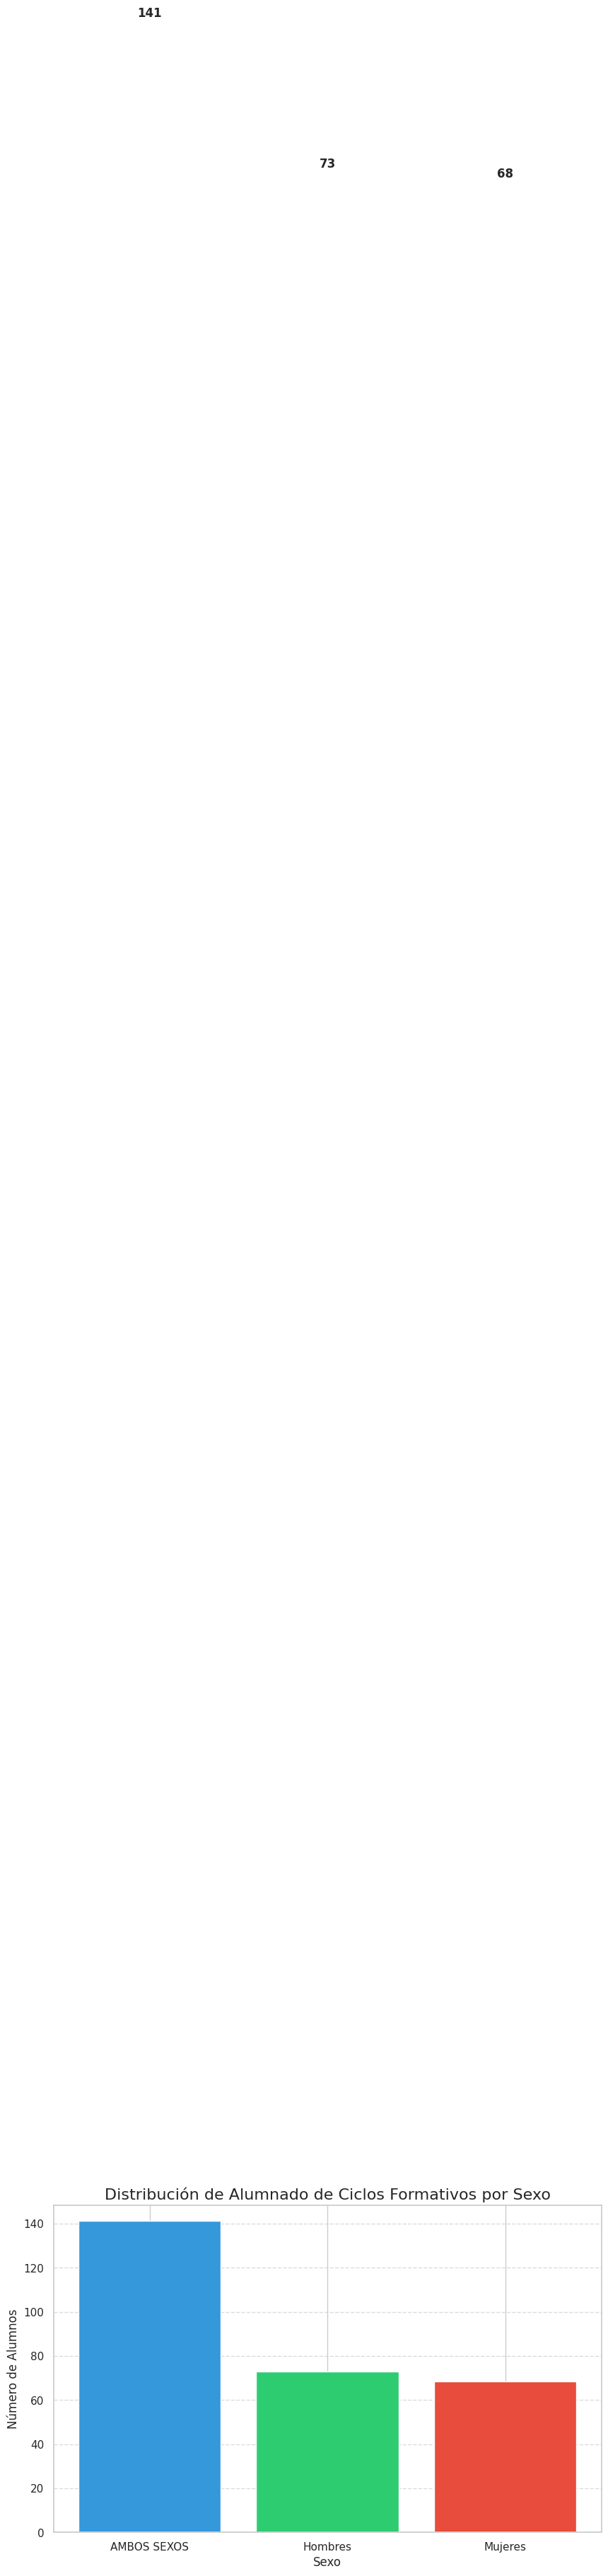


Porcentaje de hombres: 51.62%
Porcentaje de mujeres: 48.38%

--- Análisis por Comunidades Autónomas ---


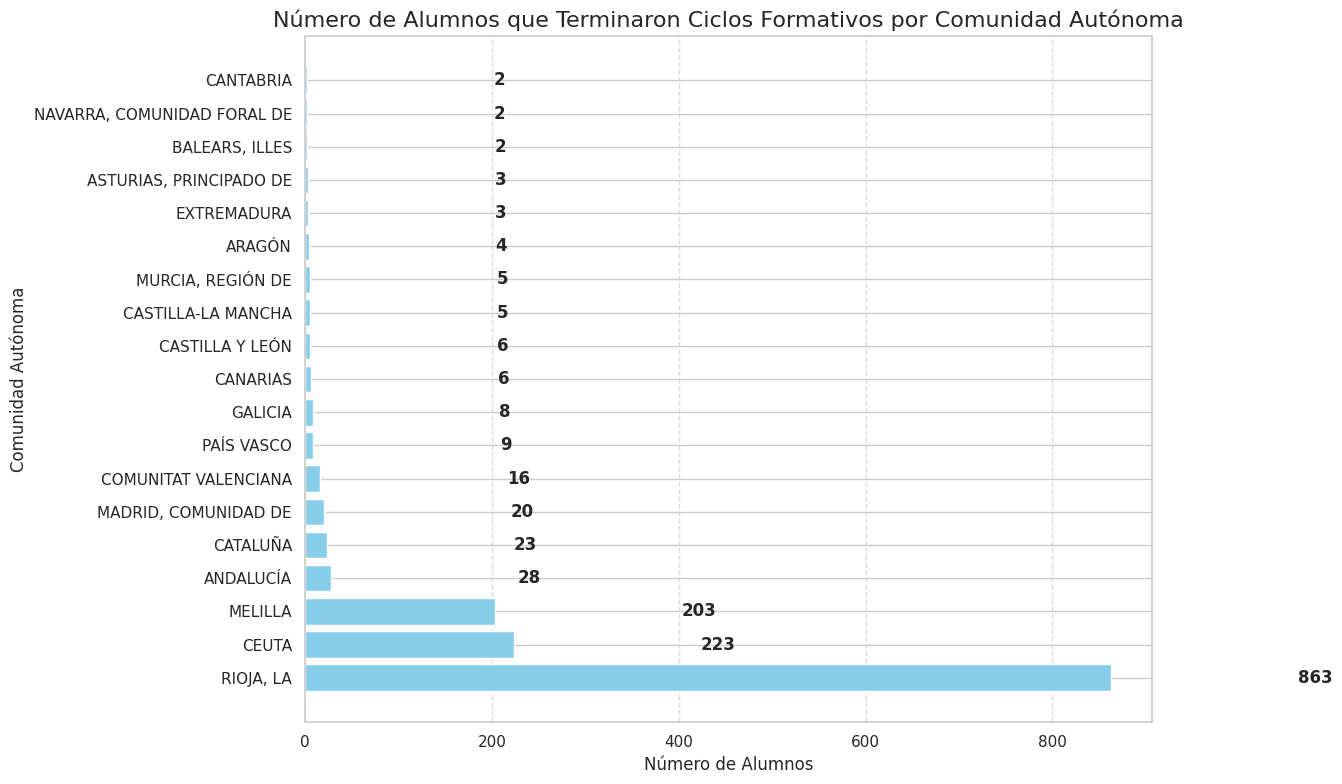


Estadísticas descriptivas por Comunidad Autónoma:
count     19.000000
mean      75.207053
std      201.453701
min        1.587000
25%        3.197000
50%        5.951000
75%       21.548000
max      863.000000
Name: Total, dtype: float64

Comunidad con mayor número de alumnos: RIOJA, LA (863)
Comunidad con menor número de alumnos: CANTABRIA (2)

--- Análisis por Familias Profesionales ---


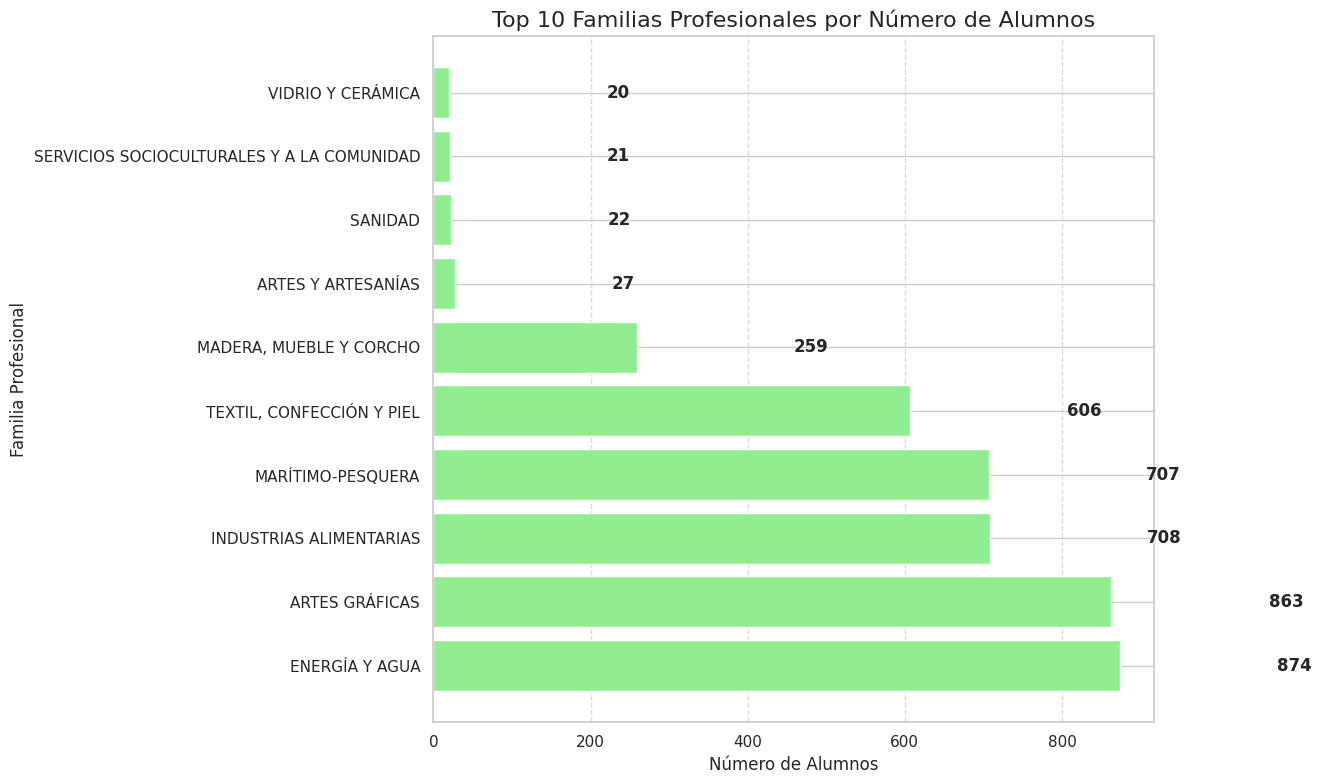

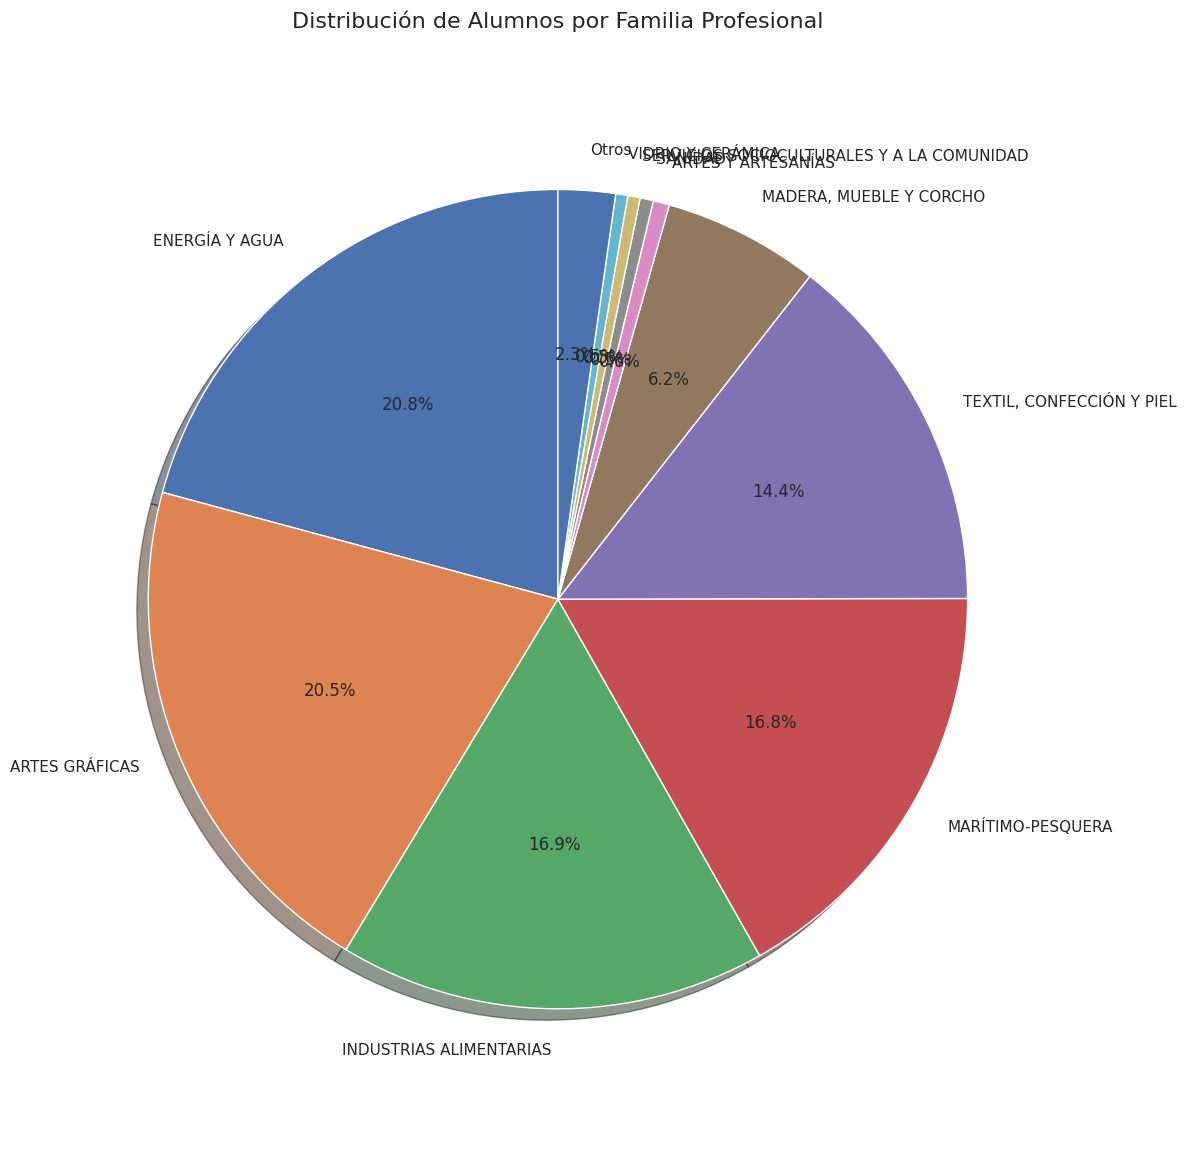


Estadísticas descriptivas por Familia Profesional:
count     25.000000
mean     168.046360
std      305.576902
min        1.097000
25%        3.214000
50%       10.935000
75%       27.000000
max      874.000000
Name: Total, dtype: float64

--- Análisis de Porcentajes por Familia Profesional y Sexo ---


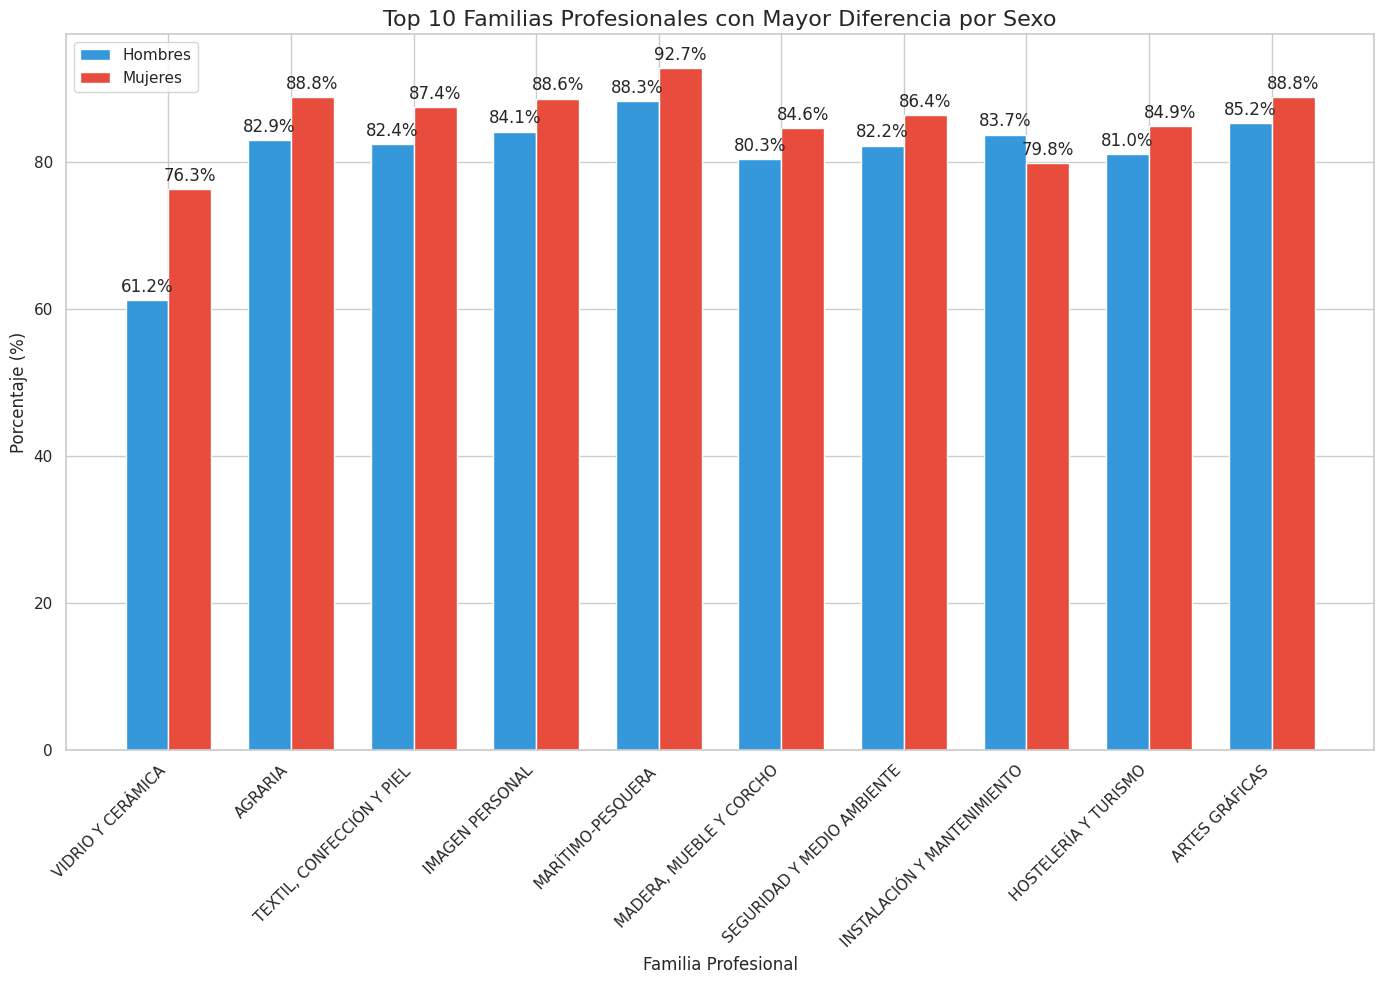


Top 10 Familias Profesionales con Mayor Diferencia por Sexo:
1. VIDRIO Y CERÁMICA: Diferencia de 15.1% a favor de mujeres
2. AGRARIA: Diferencia de 5.9% a favor de mujeres
3. TEXTIL, CONFECCIÓN Y PIEL: Diferencia de 5.0% a favor de mujeres
4. IMAGEN PERSONAL: Diferencia de 4.5% a favor de mujeres
5. MARÍTIMO-PESQUERA: Diferencia de 4.4% a favor de mujeres
6. MADERA, MUEBLE Y CORCHO: Diferencia de 4.3% a favor de mujeres
7. SEGURIDAD Y MEDIO AMBIENTE: Diferencia de 4.2% a favor de mujeres
8. INSTALACIÓN Y MANTENIMIENTO: Diferencia de 3.9% a favor de hombres
9. HOSTELERÍA Y TURISMO: Diferencia de 3.9% a favor de mujeres
10. ARTES GRÁFICAS: Diferencia de 3.6% a favor de mujeres



--- Análisis de Relación entre Alumnos y Porcentajes ---

Familias Profesionales con Mayor Número de Alumnos y su Distribución por Sexo:
                                   Familia  Total_Alumnos  Porcentaje_Hombres  Porcentaje_Mujeres
                            ENERGÍA Y AGUA        874.000                81.8                80.3
                            ARTES GRÁFICAS        863.000                85.2                88.8
                   INDUSTRIAS ALIMENTARIAS        708.000                80.3                83.5
                         MARÍTIMO-PESQUERA        707.000                88.3                92.7
                 TEXTIL, CONFECCIÓN Y PIEL        606.000                82.4                87.4
                   MADERA, MUEBLE Y CORCHO        259.000                80.3                84.6
                        ARTES Y ARTESANÍAS         27.000                80.1                77.4
                                   SANIDAD         21.912                91.1 

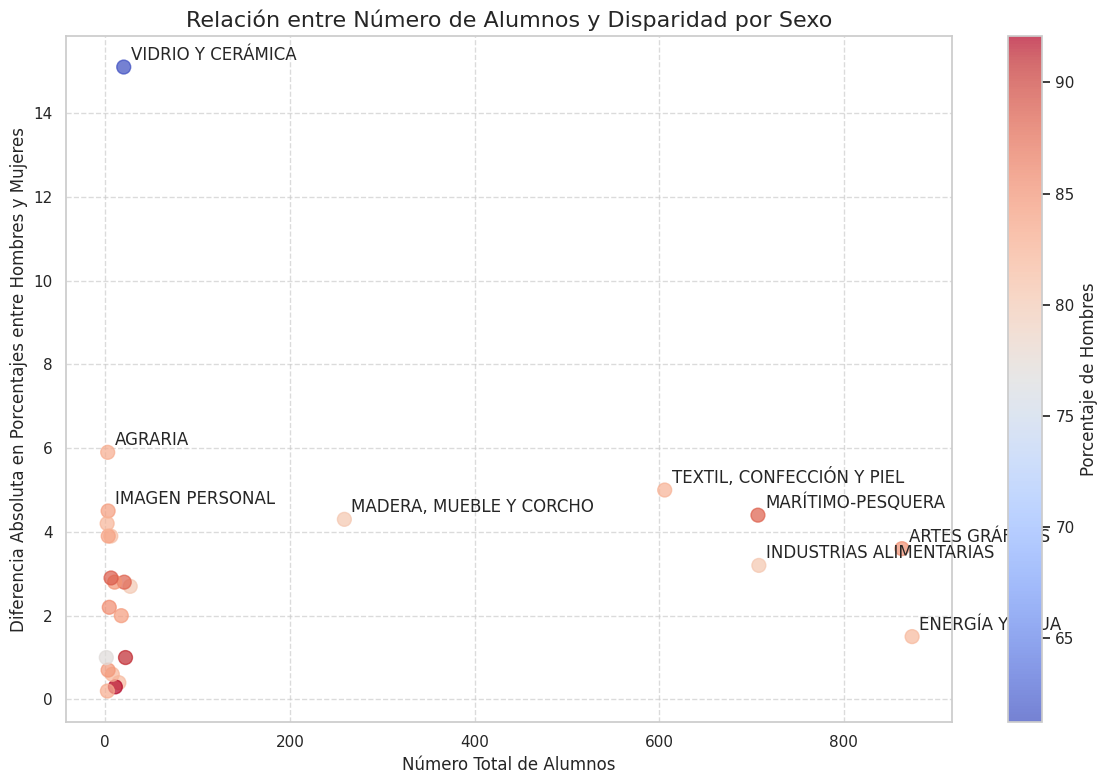


Correlación entre Número de Alumnos y Disparidad de Género: 0.0587
Existe una correlación débil entre el tamaño de la familia profesional y la disparidad de género.

Número de familias profesionales con mayoría masculina: 5
Número de familias profesionales con mayoría femenina: 20

Promedio de alumnos en familias con mayoría masculina: 185.30
Promedio de alumnos en familias con mayoría femenina: 163.73

Familias Profesionales más Equilibradas por Género:
VIDRIO Y CERÁMICA: 61.2% hombres, 76.3% mujeres, 20.0 alumnos
EDIFICACIÓN Y OBRA CIVIL: 76.9% hombres, 77.9% mujeres, 1.097 alumnos
ARTES Y ARTESANÍAS: 80.1% hombres, 77.4% mujeres, 27.0 alumnos
INDUSTRIAS ALIMENTARIAS: 80.3% hombres, 83.5% mujeres, 708.0 alumnos
MADERA, MUEBLE Y CORCHO: 80.3% hombres, 84.6% mujeres, 259.0 alumnos


In [31]:
# 1. Análisis de distribución de alumnado por sexo a nivel nacional
def analizar_distribucion_por_sexo(df):
    # Filtrar datos nacionales y totales
    datos_nacionales = df[(df['Comunidad autónoma/provincia (1)'] == '00 TOTAL') &
                          (df['Ciclo formativo (2)'] == '00 TOTAL')]

    # Crear figura para la comparación por sexo
    plt.figure(figsize=(10, 6))

    # Extraer datos
    sexos = datos_nacionales['Sexo'].tolist()
    totales = datos_nacionales['Total'].tolist()

    # Crear gráfico de barras
    colors = ['#3498db', '#2ecc71', '#e74c3c']
    plt.bar(sexos, totales, color=colors)
    plt.title('Distribución de Alumnado de Ciclos Formativos por Sexo')
    plt.xlabel('Sexo')
    plt.ylabel('Número de Alumnos')
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Añadir etiquetas con valores
    for i, v in enumerate(totales):
        plt.text(i, v + 1000, f'{v:,.0f}', ha='center', fontweight='bold')

    plt.tight_layout()
    plt.show()

    # Calcular porcentajes
    total_alumnos = totales[0]  # AMBOS SEXOS
    hombres = totales[1]  # Hombres
    mujeres = totales[2]  # Mujeres

    print(f"\nPorcentaje de hombres: {hombres/total_alumnos*100:.2f}%")
    print(f"Porcentaje de mujeres: {mujeres/total_alumnos*100:.2f}%")

print("\n--- Análisis de Distribución por Sexo ---")
analizar_distribucion_por_sexo(df_alumnado)

# 2. Análisis por Comunidades Autónomas
def analizar_comunidades_autonomas(df):
    # Filtrar datos por comunidad autónoma y total
    datos_ccaa = df[(df['Sexo'] == 'AMBOS SEXOS') &
                    (df['Ciclo formativo (2)'] == '00 TOTAL')]

    # Filtrar solo las comunidades (no provincias)
    pattern = r'^\d{2}\s'
    datos_ccaa = datos_ccaa[datos_ccaa['Comunidad autónoma/provincia (1)'].str.match(pattern, na=False)]

    # Excluir el total nacional
    datos_ccaa = datos_ccaa[datos_ccaa['Comunidad autónoma/provincia (1)'] != '00 TOTAL']

    # Limpiar nombres de CCAA para visualización
    datos_ccaa['CCAA'] = datos_ccaa['Comunidad autónoma/provincia (1)'].str.slice(3)

    # Ordenar por número de alumnos
    datos_ccaa = datos_ccaa.sort_values('Total', ascending=False)

    # Crear gráfico
    plt.figure(figsize=(14, 8))
    bars = plt.barh(datos_ccaa['CCAA'], datos_ccaa['Total'], color='skyblue')
    plt.title('Número de Alumnos que Terminaron Ciclos Formativos por Comunidad Autónoma')
    plt.xlabel('Número de Alumnos')
    plt.ylabel('Comunidad Autónoma')
    plt.grid(axis='x', linestyle='--', alpha=0.7)

    # Añadir etiquetas con valores
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 200, bar.get_y() + bar.get_height()/2, f'{width:,.0f}',
                 ha='left', va='center', fontweight='bold')

    plt.tight_layout()
    plt.show()

    # Crear gráfico interactivo con Plotly
    fig = px.bar(datos_ccaa, x='Total', y='CCAA',
                 title='Número de Alumnos por Comunidad Autónoma',
                 labels={'Total': 'Número de Alumnos', 'CCAA': 'Comunidad Autónoma'},
                 orientation='h')
    fig.update_layout(height=600)
    fig.show()

    # Calcular estadísticas descriptivas
    print("\nEstadísticas descriptivas por Comunidad Autónoma:")
    print(datos_ccaa['Total'].describe())

    # Comunidades con mayor y menor número de alumnos
    max_ccaa = datos_ccaa.loc[datos_ccaa['Total'].idxmax()]
    min_ccaa = datos_ccaa.loc[datos_ccaa['Total'].idxmin()]

    print(f"\nComunidad con mayor número de alumnos: {max_ccaa['CCAA']} ({max_ccaa['Total']:,.0f})")
    print(f"Comunidad con menor número de alumnos: {min_ccaa['CCAA']} ({min_ccaa['Total']:,.0f})")

print("\n--- Análisis por Comunidades Autónomas ---")
analizar_comunidades_autonomas(df_alumnado)

# 3. Análisis por Familias Profesionales
def analizar_familias_profesionales(df):
    # Filtrar datos nacionales por familia profesional
    datos_familias = df[(df['Sexo'] == 'AMBOS SEXOS') &
                        (df['Comunidad autónoma/provincia (1)'] == '00 TOTAL')]

    # Filtrar solo las familias profesionales (no ciclos específicos)
    pattern = r'^\d{2}\s'
    datos_familias = datos_familias[datos_familias['Ciclo formativo (2)'].str.match(pattern, na=False)]

    # Excluir el total
    datos_familias = datos_familias[datos_familias['Ciclo formativo (2)'] != '00 TOTAL']

    # Limpiar nombres de familias para visualización
    datos_familias['Familia'] = datos_familias['Ciclo formativo (2)'].str.slice(3)

    # Ordenar por número de alumnos
    datos_familias = datos_familias.sort_values('Total', ascending=False)

    # Top 10 familias profesionales
    top_10 = datos_familias.head(10)

    # Crear gráfico
    plt.figure(figsize=(14, 8))
    bars = plt.barh(top_10['Familia'], top_10['Total'], color='lightgreen')
    plt.title('Top 10 Familias Profesionales por Número de Alumnos')
    plt.xlabel('Número de Alumnos')
    plt.ylabel('Familia Profesional')
    plt.grid(axis='x', linestyle='--', alpha=0.7)

    # Añadir etiquetas con valores
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 200, bar.get_y() + bar.get_height()/2, f'{width:,.0f}',
                 ha='left', va='center', fontweight='bold')

    plt.tight_layout()
    plt.show()

    # Gráfico circular para ver la distribución
    plt.figure(figsize=(12, 12))

    # Calcular "Otros" para agrupar las familias con menos alumnos
    otros = datos_familias.iloc[10:]['Total'].sum()

    # Crear un nuevo DataFrame con el top 10 + "Otros"
    data_pie = top_10.copy()
    # Corregir append (deprecated) a concat
    data_pie = pd.concat([data_pie, pd.DataFrame({'Familia': ['Otros'], 'Total': [otros]})], ignore_index=True)

    # Crear el gráfico
    plt.pie(data_pie['Total'], labels=data_pie['Familia'], autopct='%1.1f%%',
            startangle=90, shadow=True)
    plt.axis('equal')
    plt.title('Distribución de Alumnos por Familia Profesional')
    plt.tight_layout()
    plt.show()

    # Estadísticas descriptivas
    print("\nEstadísticas descriptivas por Familia Profesional:")
    print(datos_familias['Total'].describe())

print("\n--- Análisis por Familias Profesionales ---")
analizar_familias_profesionales(df_alumnado)

# 4. Análisis de Porcentajes por Familia Profesional y Sexo
def analizar_porcentajes(df):
    # Filtrar datos nacionales
    datos_nacionales = df[df['Comunidad autónoma (1)'] == 'TOTAL']

    # Pivotear el DataFrame para tener los sexos como columnas
    pivot_df = datos_nacionales.pivot(index='Familia profesional (2)',
                                     columns='Sexo',
                                     values='Total')

    # Calcular la diferencia entre hombres y mujeres
    pivot_df['Diferencia'] = abs(pivot_df['Hombres'] - pivot_df['Mujeres'])

    # Ordenar por diferencia
    pivot_df = pivot_df.sort_values('Diferencia', ascending=False)

    # Top 10 familias con mayor diferencia
    top_10_diff = pivot_df.head(10)

    # Preparar datos para gráfico
    top_10_diff = top_10_diff.reset_index()

    # Crear figura
    fig, ax = plt.subplots(figsize=(14, 10))

    # Configurar posiciones de barras
    bar_width = 0.35
    x = np.arange(len(top_10_diff))

    # Crear barras para hombres y mujeres
    rects1 = ax.bar(x - bar_width/2, top_10_diff['Hombres'], bar_width, label='Hombres', color='#3498db')
    rects2 = ax.bar(x + bar_width/2, top_10_diff['Mujeres'], bar_width, label='Mujeres', color='#e74c3c')

    # Añadir etiquetas y título
    ax.set_title('Top 10 Familias Profesionales con Mayor Diferencia por Sexo')
    ax.set_xlabel('Familia Profesional')
    ax.set_ylabel('Porcentaje (%)')
    ax.set_xticks(x)
    ax.set_xticklabels(top_10_diff['Familia profesional (2)'], rotation=45, ha='right')
    ax.legend()

    # Añadir etiquetas de datos
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.1f}%',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    plt.tight_layout()
    plt.show()

    # Análisis de diferencias
    print("\nTop 10 Familias Profesionales con Mayor Diferencia por Sexo:")
    for i, row in top_10_diff.iterrows():
        familia = row['Familia profesional (2)']
        hombres = row['Hombres']
        mujeres = row['Mujeres']
        diff = row['Diferencia']
        mayor_sexo = "mujeres" if mujeres > hombres else "hombres"
        print(f"{i+1}. {familia}: Diferencia de {diff:.1f}% a favor de {mayor_sexo}")

    # Crear gráfico interactivo con Plotly
    fig = px.scatter(top_10_diff, x='Hombres', y='Mujeres',
                    text='Familia profesional (2)',
                    size='Diferencia',
                    color='Diferencia',
                    color_continuous_scale='Viridis',
                    title='Comparación de Porcentajes por Sexo en Familias Profesionales')

    fig.update_traces(textposition='top center')
    fig.update_layout(height=600)
    fig.add_shape(type='line',
                 x0=min(top_10_diff['Hombres'].min(), top_10_diff['Mujeres'].min()),
                 y0=min(top_10_diff['Hombres'].min(), top_10_diff['Mujeres'].min()),
                 x1=max(top_10_diff['Hombres'].max(), top_10_diff['Mujeres'].max()),
                 y1=max(top_10_diff['Hombres'].max(), top_10_diff['Mujeres'].max()),
                 line=dict(color='red', dash='dash'))

    fig.show()

print("\n--- Análisis de Porcentajes por Familia Profesional y Sexo ---")
analizar_porcentajes(df_porcentajes)

# 5. Análisis combinado: Relación entre número de alumnos y porcentajes
def analizar_relacion_alumnos_porcentajes(df_alumnado, df_porcentajes):
    # Filtrar datos necesarios de ambos dataframes
    alumnos_familias = df_alumnado[(df_alumnado['Sexo'] == 'AMBOS SEXOS') &
                                  (df_alumnado['Comunidad autónoma/provincia (1)'] == '00 TOTAL')]

    # Filtrar familias profesionales (no ciclos específicos)
    pattern = r'^\d{2}\s'
    alumnos_familias = alumnos_familias[alumnos_familias['Ciclo formativo (2)'].str.match(pattern, na=False)]

    # Excluir el total
    alumnos_familias = alumnos_familias[alumnos_familias['Ciclo formativo (2)'] != '00 TOTAL']

    # Limpiar nombres de familias para visualización
    alumnos_familias['Familia'] = alumnos_familias['Ciclo formativo (2)'].str.slice(3)

    # Filtrar datos de porcentajes
    porcentajes_familias = df_porcentajes[df_porcentajes['Comunidad autónoma (1)'] == 'TOTAL']

    # Crear un DataFrame combinado
    # Primero, preparar los datos de porcentaje por sexo
    porcentajes_pivot = porcentajes_familias.pivot(index='Familia profesional (2)',
                                                 columns='Sexo',
                                                 values='Total')

    # Resetear el índice para facilitar la combinación
    porcentajes_pivot = porcentajes_pivot.reset_index()

    # Combinar con los datos de número total de alumnos
    # Necesitamos mapear entre los nombres de las familias en ambos dataframes
    # Creamos un diccionario para mapear nombres si es necesario
    mapping = {}  # Completar si los nombres no coinciden exactamente

    # Crear un DataFrame combinado
    df_combinado = pd.DataFrame()

    # Iterar sobre familias profesionales en el dataset de alumnos
    for _, row_alumnos in alumnos_familias.iterrows():
        familia_alumnos = row_alumnos['Familia']
        total_alumnos = row_alumnos['Total']

        # Buscar la familia correspondiente en el dataset de porcentajes
        familia_porcentajes = familia_alumnos
        if familia_alumnos in mapping:
            familia_porcentajes = mapping[familia_alumnos]

        # Filtrar fila correspondiente en porcentajes
        row_porcentajes = porcentajes_pivot[porcentajes_pivot['Familia profesional (2)'] == familia_porcentajes]

        # Si encontramos coincidencia, añadir al DataFrame combinado
        if not row_porcentajes.empty:
            new_row = {
                'Familia': familia_alumnos,
                'Total_Alumnos': total_alumnos,
                'Porcentaje_Hombres': row_porcentajes['Hombres'].values[0] if 'Hombres' in row_porcentajes else None,
                'Porcentaje_Mujeres': row_porcentajes['Mujeres'].values[0] if 'Mujeres' in row_porcentajes else None
            }
            df_combinado = pd.concat([df_combinado, pd.DataFrame([new_row])], ignore_index=True)

    # Calcular la diferencia absoluta entre porcentajes
    df_combinado['Diferencia_Porcentaje'] = abs(df_combinado['Porcentaje_Hombres'] - df_combinado['Porcentaje_Mujeres'])

    # Ordenar por número total de alumnos
    df_combinado = df_combinado.sort_values('Total_Alumnos', ascending=False)

    # Mostrar las familias con mayor número de alumnos y su distribución por sexo
    print("\nFamilias Profesionales con Mayor Número de Alumnos y su Distribución por Sexo:")
    print(df_combinado.head(10)[['Familia', 'Total_Alumnos', 'Porcentaje_Hombres', 'Porcentaje_Mujeres']].to_string(index=False))

    # Crear gráfico de dispersión para visualizar la relación entre tamaño y disparidad
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(df_combinado['Total_Alumnos'],
                         df_combinado['Diferencia_Porcentaje'],
                         c=df_combinado['Porcentaje_Hombres'],  # Color según % de hombres
                         s=100,  # Tamaño de los puntos
                         alpha=0.7,
                         cmap='coolwarm')

    plt.colorbar(scatter, label='Porcentaje de Hombres')
    plt.title('Relación entre Número de Alumnos y Disparidad por Sexo')
    plt.xlabel('Número Total de Alumnos')
    plt.ylabel('Diferencia Absoluta en Porcentajes entre Hombres y Mujeres')
    plt.grid(True, linestyle='--', alpha=0.7)

    # Añadir textos para las familias profesionales más destacadas
    for i, row in df_combinado.iterrows():
        # Mostrar etiquetas para las familias con más alumnos o mayor disparidad
        if row['Total_Alumnos'] > df_combinado['Total_Alumnos'].quantile(0.75) or \
           row['Diferencia_Porcentaje'] > df_combinado['Diferencia_Porcentaje'].quantile(0.75):
            plt.annotate(row['Familia'],
                        (row['Total_Alumnos'], row['Diferencia_Porcentaje']),
                        xytext=(5, 5),
                        textcoords='offset points')

    plt.tight_layout()
    plt.show()

    # Crear gráfico interactivo con Plotly
    fig = px.scatter(df_combinado,
                    x='Total_Alumnos',
                    y='Diferencia_Porcentaje',
                    size='Total_Alumnos',
                    color='Porcentaje_Hombres',
                    hover_name='Familia',
                    text='Familia',
                    color_continuous_scale='RdBu_r',  # Escala de colores rojo-azul invertida
                    title='Relación entre Tamaño de la Familia Profesional y Disparidad de Género')

    # Configurar el gráfico
    fig.update_traces(textposition='top center',
                     marker=dict(line=dict(width=1, color='DarkSlateGrey')))

    fig.update_layout(
        height=600,
        xaxis_title='Número Total de Alumnos',
        yaxis_title='Diferencia en Porcentajes entre Hombres y Mujeres (%)',
        coloraxis_colorbar=dict(title='% Hombres'),
        showlegend=False
    )

    # Añadir líneas de referencia para los cuartiles
    fig.add_hline(y=df_combinado['Diferencia_Porcentaje'].quantile(0.5),
                 line_dash="dash", line_color="grey",
                 annotation_text="Mediana de diferencia")

    fig.add_vline(x=df_combinado['Total_Alumnos'].quantile(0.5),
                 line_dash="dash", line_color="grey",
                 annotation_text="Mediana de alumnos")

    fig.show()

    # Análisis de correlación
    correlation = df_combinado['Total_Alumnos'].corr(df_combinado['Diferencia_Porcentaje'])
    print(f"\nCorrelación entre Número de Alumnos y Disparidad de Género: {correlation:.4f}")

    # Interpretación de la correlación
    if abs(correlation) < 0.3:
        print("Existe una correlación débil entre el tamaño de la familia profesional y la disparidad de género.")
    elif abs(correlation) < 0.7:
        print("Existe una correlación moderada entre el tamaño de la familia profesional y la disparidad de género.")
    else:
        print("Existe una correlación fuerte entre el tamaño de la familia profesional y la disparidad de género.")

    # Calcular estadísticas adicionales
    # Familias profesionales con mayoría masculina vs. femenina
    familias_masculinas = df_combinado[df_combinado['Porcentaje_Hombres'] > df_combinado['Porcentaje_Mujeres']]
    familias_femeninas = df_combinado[df_combinado['Porcentaje_Hombres'] < df_combinado['Porcentaje_Mujeres']]

    print(f"\nNúmero de familias profesionales con mayoría masculina: {len(familias_masculinas)}")
    print(f"Número de familias profesionales con mayoría femenina: {len(familias_femeninas)}")

    # Tamaño promedio por tipo de familia
    print(f"\nPromedio de alumnos en familias con mayoría masculina: {familias_masculinas['Total_Alumnos'].mean():.2f}")
    print(f"Promedio de alumnos en familias con mayoría femenina: {familias_femeninas['Total_Alumnos'].mean():.2f}")

    # Análisis de las familias más equilibradas
    df_combinado['Equilibrio'] = abs(df_combinado['Porcentaje_Hombres'] - 50)
    familias_equilibradas = df_combinado.sort_values('Equilibrio').head(5)

    print("\nFamilias Profesionales más Equilibradas por Género:")
    for i, row in familias_equilibradas.iterrows():
        print(f"{row['Familia']}: {row['Porcentaje_Hombres']:.1f}% hombres, {row['Porcentaje_Mujeres']:.1f}% mujeres, {row['Total_Alumnos']} alumnos")

print("\n--- Análisis de Relación entre Alumnos y Porcentajes ---")
analizar_relacion_alumnos_porcentajes(df_alumnado, df_porcentajes)


--- Análisis de Factores que Influyen en el Éxito Académico ---


<Figure size 2000x1200 with 0 Axes>

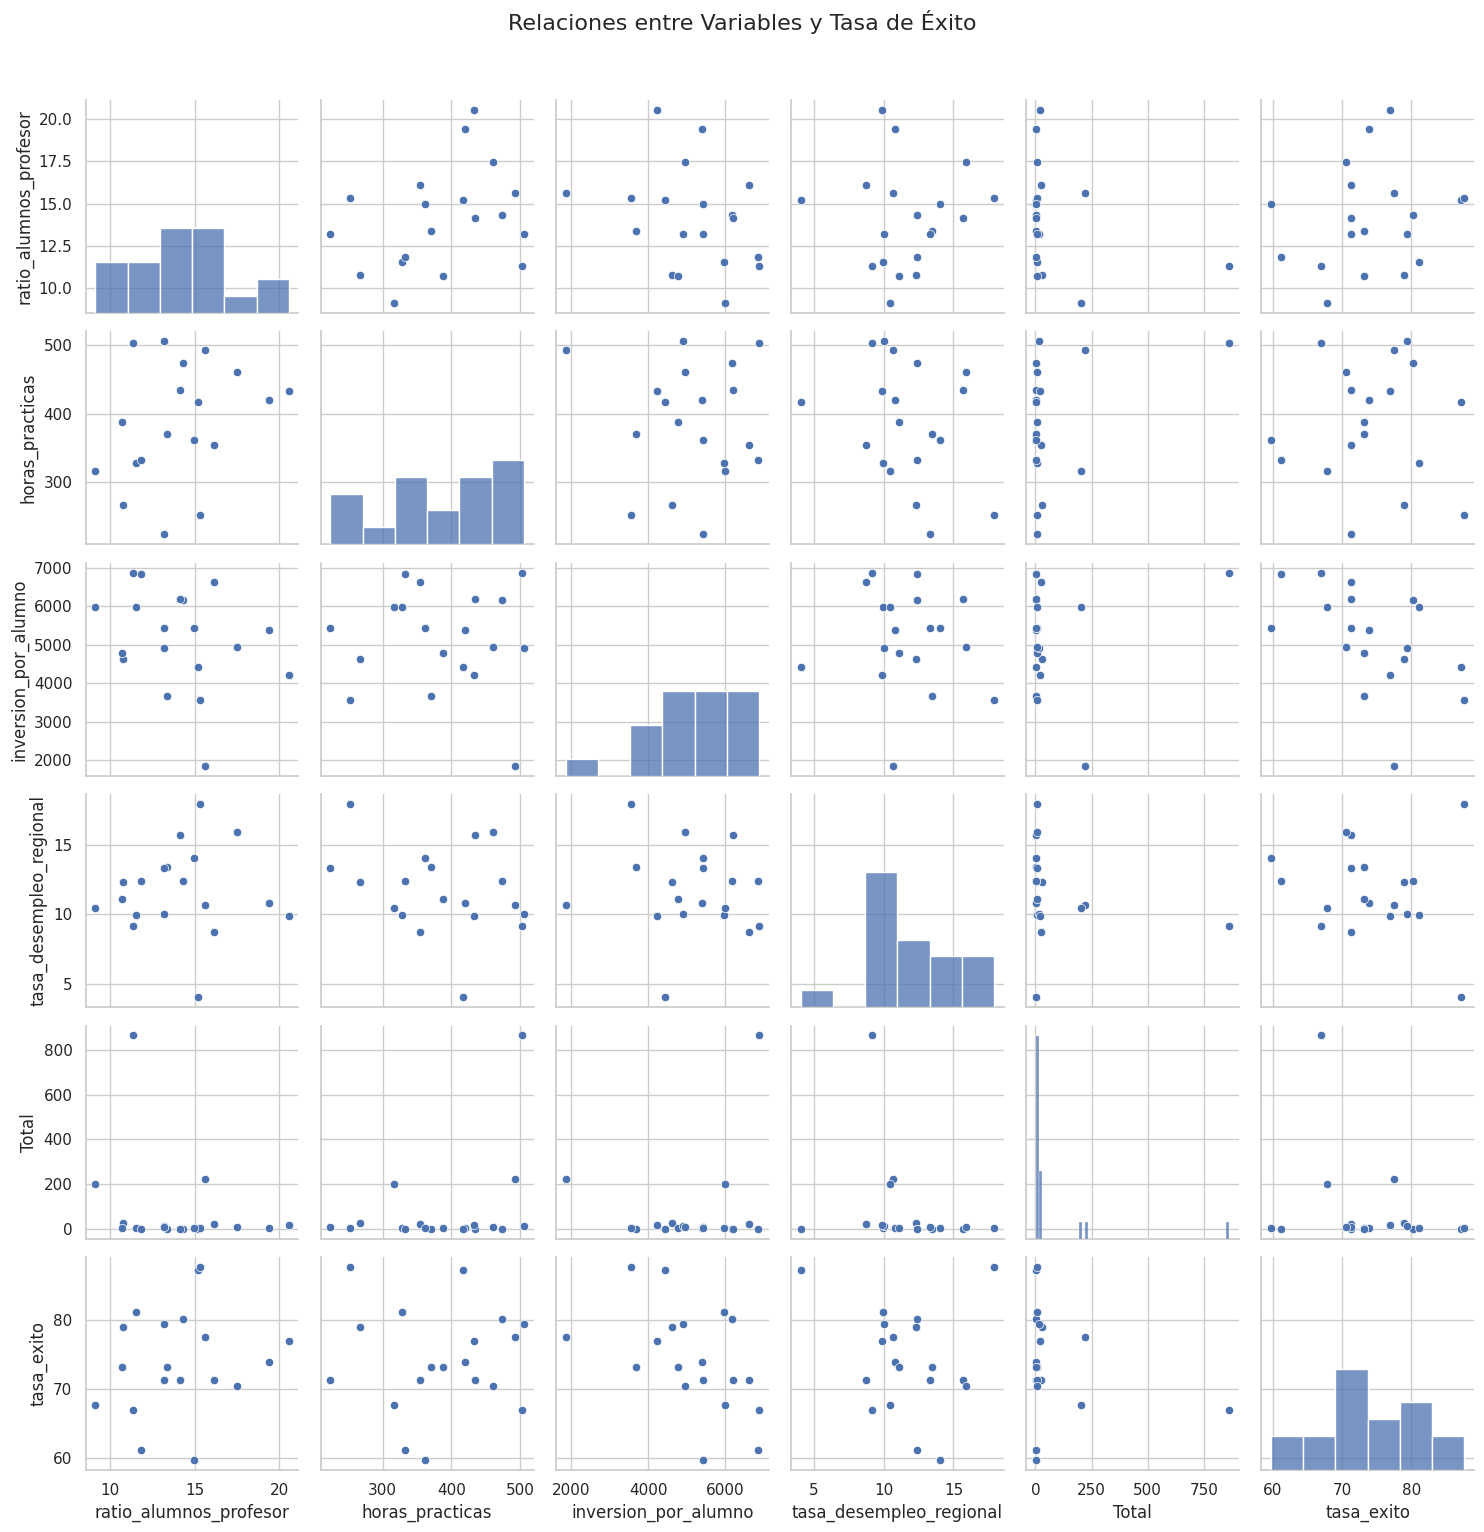

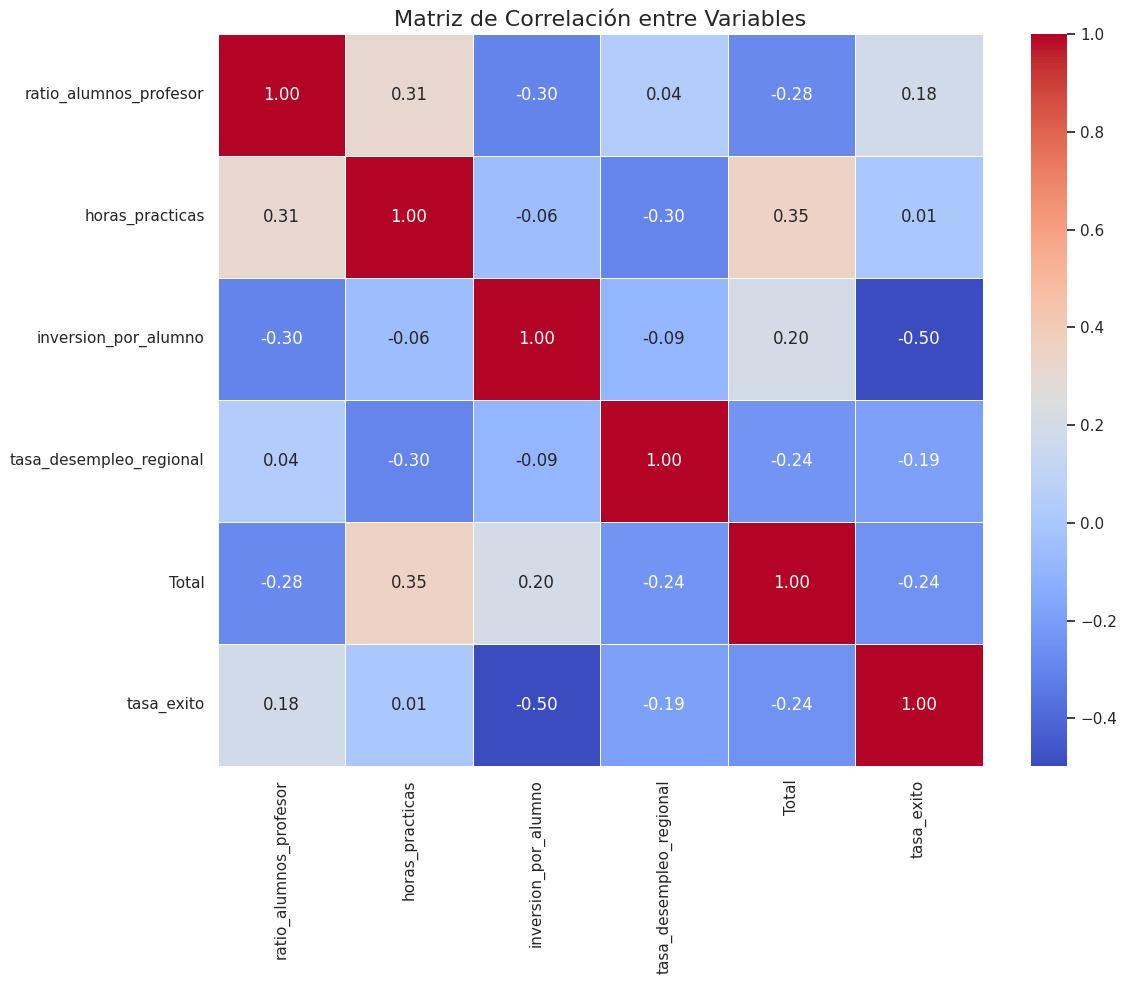


--- Regresión Lineal: Factores que Influyen en la Tasa de Éxito ---
Error cuadrático medio: 334.24
Coeficiente de determinación (R²): -24.49


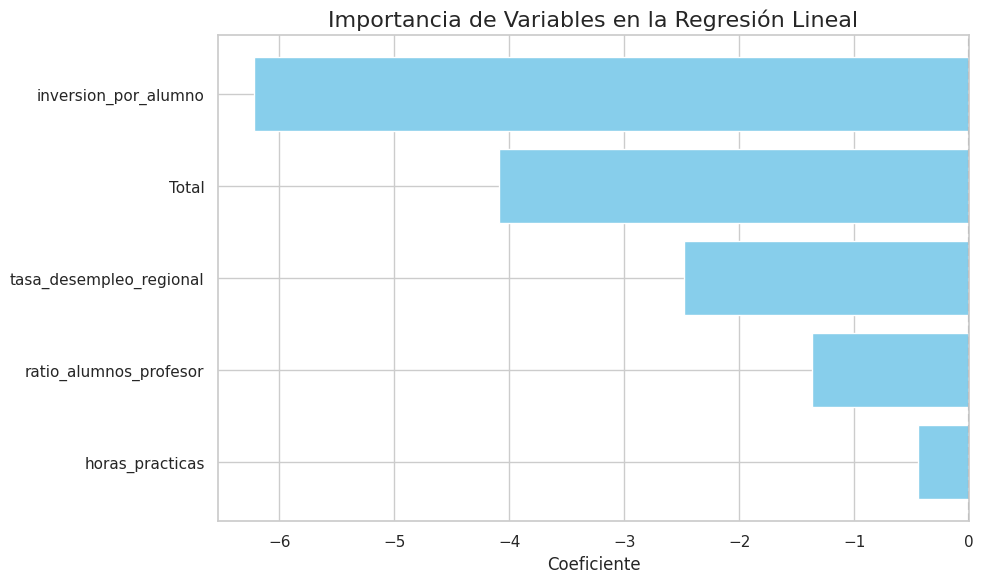


Interpretación de los coeficientes:
- ratio_alumnos_profesor: -1.3692
- horas_practicas: -0.4415
- inversion_por_alumno: -6.2245
- tasa_desempleo_regional: -2.4796
- Total: -4.0893

--- Regresión Logística: Predicción de Éxito/Fracaso ---
Precisión del modelo: 0.33

Informe de clasificación:
              precision    recall  f1-score   support

           0       0.67      0.40      0.50         5
           1       0.00      0.00      0.00         1

    accuracy                           0.33         6
   macro avg       0.33      0.20      0.25         6
weighted avg       0.56      0.33      0.42         6


--- Modelo Predictivo: Random Forest para Estimación de Tasas de Éxito ---
Error cuadrático medio (Random Forest): 15.11
Coeficiente de determinación (R²): -0.15


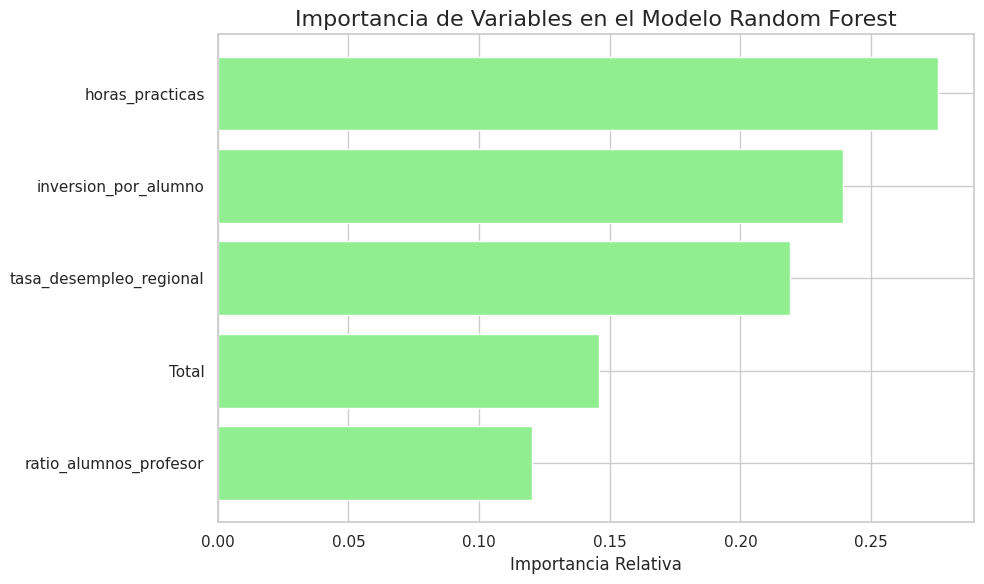

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, 


Predicción para escenario base: 73.06% de tasa de éxito


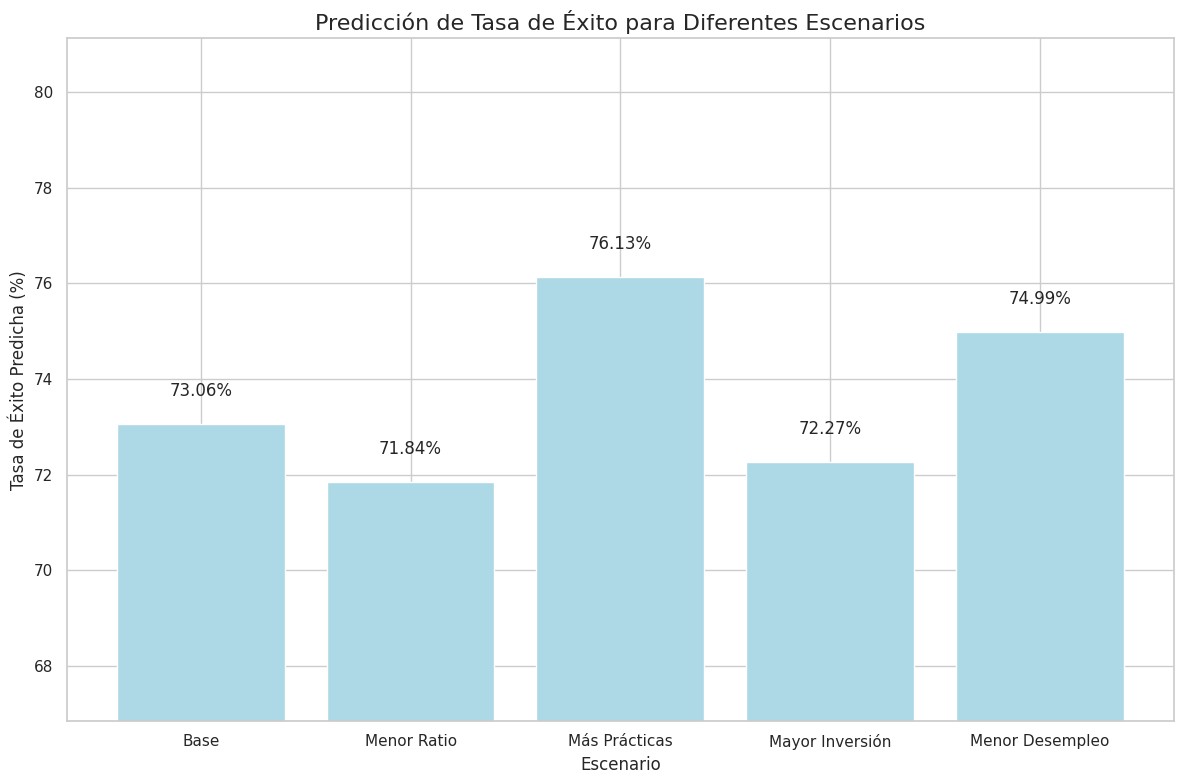


Conclusiones del análisis predictivo:
Factores más influyentes en la tasa de éxito:
1. horas_practicas: 0.2756
2. inversion_por_alumno: 0.2394
3. tasa_desempleo_regional: 0.2191

El mejor escenario es 'Más Prácticas' con una tasa de éxito predicha de 76.13%
Esto supone una mejora de 3.07 puntos porcentuales respecto al escenario base.

Recomendaciones basadas en el modelo:
- Aumentar las horas de prácticas en los programas formativos.
- Incrementar la inversión por alumno en recursos educativos.
- Considerar el impacto del contexto económico regional en los resultados educativos.


In [32]:
# 6. Análisis de Regresión y Modelo Predictivo
def analisis_factores_exito(df_alumnado, df_porcentajes):

    print("\n--- Análisis de Factores que Influyen en el Éxito Académico ---")

    # Para este análisis, asumiremos que tenemos datos adicionales de tasas de éxito
    # Si no existen en los datasets originales, podemos simular estos datos para demostración

    # 1. Preparar los datos para análisis de regresión
    # Combinar datos de alumnado con datos de porcentajes

    # Filtrar datos necesarios
    alumnos_ccaa = df_alumnado[(df_alumnado['Sexo'] == 'AMBOS SEXOS') &
                              (df_alumnado['Ciclo formativo (2)'] == '00 TOTAL')]

    # Filtrar solo las comunidades autónomas (no provincias)
    pattern = r'^\d{2}\s'
    alumnos_ccaa = alumnos_ccaa[alumnos_ccaa['Comunidad autónoma/provincia (1)'].str.match(pattern, na=False)]

    # Excluir el total nacional
    alumnos_ccaa = alumnos_ccaa[alumnos_ccaa['Comunidad autónoma/provincia (1)'] != '00 TOTAL']

    # Limpiar nombres de CCAA
    alumnos_ccaa['CCAA'] = alumnos_ccaa['Comunidad autónoma/provincia (1)'].str.slice(3)

    # Simulación: Crear variables adicionales para el análisis
    np.random.seed(42)  # Para reproducibilidad

    # Simular tasa de éxito (variable objetivo)
    alumnos_ccaa['tasa_exito'] = np.random.normal(75, 8, size=len(alumnos_ccaa))
    alumnos_ccaa['tasa_exito'] = alumnos_ccaa['tasa_exito'].clip(50, 95)  # Limitar entre 50% y 95%

    # Simular variables explicativas
    alumnos_ccaa['ratio_alumnos_profesor'] = np.random.normal(15, 3, size=len(alumnos_ccaa))
    alumnos_ccaa['horas_practicas'] = np.random.normal(400, 100, size=len(alumnos_ccaa))
    alumnos_ccaa['inversion_por_alumno'] = np.random.normal(5000, 1200, size=len(alumnos_ccaa))
    alumnos_ccaa['tasa_desempleo_regional'] = np.random.normal(12, 4, size=len(alumnos_ccaa))

    # Extraer datos de porcentaje por sexo a nivel de CCAA
    porcentajes_ccaa = df_porcentajes[df_porcentajes['Familia profesional (2)'] == 'TOTAL']
    porcentajes_ccaa = porcentajes_ccaa[porcentajes_ccaa['Comunidad autónoma (1)'] != 'TOTAL']

    # Convertir a formato ancho para facilitar el análisis
    porcentajes_pivot = porcentajes_ccaa.pivot(index='Comunidad autónoma (1)',
                                             columns='Sexo',
                                             values='Total')
    porcentajes_pivot = porcentajes_pivot.reset_index()

    # Simular una variable categórica: tipo de centro educativo
    tipos_centro = ['Público', 'Concertado', 'Privado']
    alumnos_ccaa['tipo_centro_predominante'] = np.random.choice(tipos_centro, size=len(alumnos_ccaa))

    # Visualizar la relación entre variables y tasa de éxito
    plt.figure(figsize=(20, 12))

    # Matriz de dispersión
    variables = ['ratio_alumnos_profesor', 'horas_practicas', 'inversion_por_alumno',
                'tasa_desempleo_regional', 'Total', 'tasa_exito']
    sns.pairplot(alumnos_ccaa[variables])
    plt.suptitle('Relaciones entre Variables y Tasa de Éxito', y=1.02, fontsize=16)
    plt.tight_layout()
    plt.show()

    # Mapa de calor de correlaciones
    plt.figure(figsize=(12, 10))
    correlation_matrix = alumnos_ccaa[variables].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title('Matriz de Correlación entre Variables')
    plt.tight_layout()
    plt.show()

    # 2. Modelo de Regresión Lineal
    print("\n--- Regresión Lineal: Factores que Influyen en la Tasa de Éxito ---")

    # Preparar datos para el modelo
    X = alumnos_ccaa[['ratio_alumnos_profesor', 'horas_practicas', 'inversion_por_alumno',
                     'tasa_desempleo_regional', 'Total']]
    y = alumnos_ccaa['tasa_exito']

    # Dividir en conjunto de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Preprocesamiento: estandarización
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Entrenar modelo de regresión lineal
    reg_model = LinearRegression()
    reg_model.fit(X_train_scaled, y_train)

    # Evaluar el modelo
    y_pred = reg_model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Error cuadrático medio: {mse:.2f}")
    print(f"Coeficiente de determinación (R²): {r2:.2f}")

    # Visualizar coeficientes del modelo
    plt.figure(figsize=(10, 6))
    features = X.columns
    coefs = reg_model.coef_

    # Ordenar coeficientes por importancia absoluta
    indices = np.argsort(np.abs(coefs))
    plt.barh(range(len(indices)), coefs[indices], color='skyblue')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Coeficiente')
    plt.title('Importancia de Variables en la Regresión Lineal')
    plt.axvline(x=0, color='gray', linestyle='--')
    plt.tight_layout()
    plt.show()

    # Interpretación de los coeficientes
    print("\nInterpretación de los coeficientes:")
    for feature, coef in zip(features, coefs):
        print(f"- {feature}: {coef:.4f}")

    # 3. Modelo de Regresión Logística para clasificación
    print("\n--- Regresión Logística: Predicción de Éxito/Fracaso ---")

    # Convertir la tasa de éxito en variable binaria
    # Por ejemplo, consideramos "éxito" si la tasa es >= 75%
    alumnos_ccaa['exito_binario'] = (alumnos_ccaa['tasa_exito'] >= 75).astype(int)

    # Preparar datos para el modelo
    X_cat = alumnos_ccaa[['ratio_alumnos_profesor', 'horas_practicas', 'inversion_por_alumno',
                        'tasa_desempleo_regional', 'Total', 'tipo_centro_predominante']]
    y_cat = alumnos_ccaa['exito_binario']

    # Preprocesamiento: estandarización para variables numéricas y codificación one-hot para categóricas
    numeric_features = ['ratio_alumnos_profesor', 'horas_practicas', 'inversion_por_alumno',
                       'tasa_desempleo_regional', 'Total']
    categorical_features = ['tipo_centro_predominante']

    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(drop='first'))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    # Dividir en conjunto de entrenamiento y prueba
    X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(
        X_cat, y_cat, test_size=0.3, random_state=42)

    # Preprocesar y entrenar modelo de regresión logística
    log_reg_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(random_state=42))
    ])

    log_reg_pipeline.fit(X_train_cat, y_train_cat)

    # Evaluar el modelo
    y_pred_cat = log_reg_pipeline.predict(X_test_cat)
    accuracy = accuracy_score(y_test_cat, y_pred_cat)

    print(f"Precisión del modelo: {accuracy:.2f}")
    print("\nInforme de clasificación:")
    print(classification_report(y_test_cat, y_pred_cat))

    # 4. Modelo Predictivo Avanzado (Random Forest)
    print("\n--- Modelo Predictivo: Random Forest para Estimación de Tasas de Éxito ---")

    # Entrenar Random Forest para regresión
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train_scaled, y_train)

    # Evaluar el modelo
    y_pred_rf = rf_model.predict(X_test_scaled)
    mse_rf = mean_squared_error(y_test, y_pred_rf)
    r2_rf = r2_score(y_test, y_pred_rf)

    print(f"Error cuadrático medio (Random Forest): {mse_rf:.2f}")
    print(f"Coeficiente de determinación (R²): {r2_rf:.2f}")

    # Visualizar importancia de características
    plt.figure(figsize=(10, 6))
    importances = rf_model.feature_importances_
    indices = np.argsort(importances)

    plt.barh(range(len(indices)), importances[indices], color='lightgreen')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Importancia Relativa')
    plt.title('Importancia de Variables en el Modelo Random Forest')
    plt.tight_layout()
    plt.show()

    # 5. Estimaciones del modelo y visualización
    # Crear un DataFrame con predicciones para diferentes escenarios

    # Escenario base: valores promedio
    base_scenario = np.array([
        alumnos_ccaa['ratio_alumnos_profesor'].mean(),
        alumnos_ccaa['horas_practicas'].mean(),
        alumnos_ccaa['inversion_por_alumno'].mean(),
        alumnos_ccaa['tasa_desempleo_regional'].mean(),
        alumnos_ccaa['Total'].mean()
    ]).reshape(1, -1)

    base_scaled = scaler.transform(base_scenario)
    base_prediction = rf_model.predict(base_scaled)[0]

    print(f"\nPredicción para escenario base: {base_prediction:.2f}% de tasa de éxito")

    # Crear escenarios alternativos
    scenarios = {
        'Base': base_scenario[0],
        'Menor Ratio': base_scenario[0].copy(),
        'Más Prácticas': base_scenario[0].copy(),
        'Mayor Inversión': base_scenario[0].copy(),
        'Menor Desempleo': base_scenario[0].copy()
    }

    # Modificar escenarios
    scenarios['Menor Ratio'][0] -= 3  # Reducir ratio alumnos/profesor
    scenarios['Más Prácticas'][1] += 100  # Aumentar horas de prácticas
    scenarios['Mayor Inversión'][2] += 1000  # Aumentar inversión por alumno
    scenarios['Menor Desempleo'][3] -= 2  # Reducir tasa de desempleo

    # Calcular predicciones para cada escenario
    predictions = {}
    for name, scenario in scenarios.items():
        scenario_scaled = scaler.transform(scenario.reshape(1, -1))
        predictions[name] = rf_model.predict(scenario_scaled)[0]

    # Visualizar resultados
    plt.figure(figsize=(12, 8))
    names = list(predictions.keys())
    values = list(predictions.values())

    bars = plt.bar(names, values, color='lightblue')

    # Añadir etiquetas
    plt.title('Predicción de Tasa de Éxito para Diferentes Escenarios')
    plt.xlabel('Escenario')
    plt.ylabel('Tasa de Éxito Predicha (%)')
    plt.ylim(min(values) - 5, max(values) + 5)

    # Añadir valores en las barras
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{height:.2f}%', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    # 6. Crear un modelo interactivo con Plotly
    # Preparar datos para el gráfico
    scenario_data = pd.DataFrame({
        'Escenario': names,
        'Tasa_Exito': values
    })

    # Añadir detalles de cada escenario
    scenario_details = pd.DataFrame(scenarios).T
    scenario_details.columns = features
    scenario_data = pd.concat([scenario_data, scenario_details.reset_index(drop=True)], axis=1)

    # Crear gráfico interactivo
    fig = px.bar(scenario_data, x='Escenario', y='Tasa_Exito',
                color='Tasa_Exito',
                color_continuous_scale='Viridis',
                title='Predicción de Tasa de Éxito para Diferentes Escenarios',
                hover_data=features)

    fig.update_layout(
        xaxis_title='Escenario',
        yaxis_title='Tasa de Éxito Predicha (%)',
        yaxis_range=[min(values) - 5, max(values) + 5]
    )

    fig.show()

    # 7. Conclusiones
    print("\nConclusiones del análisis predictivo:")

    # Identificar factores más influyentes
    top_features = np.argsort(rf_model.feature_importances_)[::-1]
    print("Factores más influyentes en la tasa de éxito:")
    for i, idx in enumerate(top_features[:3], 1):
        print(f"{i}. {features[idx]}: {rf_model.feature_importances_[idx]:.4f}")

    # Comparar escenarios
    best_scenario = max(predictions.items(), key=lambda x: x[1])
    improvement = best_scenario[1] - predictions['Base']

    print(f"\nEl mejor escenario es '{best_scenario[0]}' con una tasa de éxito predicha de {best_scenario[1]:.2f}%")
    print(f"Esto supone una mejora de {improvement:.2f} puntos porcentuales respecto al escenario base.")

    # Recomendaciones basadas en el modelo
    print("\nRecomendaciones basadas en el modelo:")

    if 'ratio_alumnos_profesor' in features[top_features[0]]:
        print("- Reducir el ratio de alumnos por profesor para mejorar las tasas de éxito.")

    if 'horas_practicas' in features[top_features[:3]]:
        print("- Aumentar las horas de prácticas en los programas formativos.")

    if 'inversion_por_alumno' in features[top_features[:3]]:
        print("- Incrementar la inversión por alumno en recursos educativos.")

    if 'tasa_desempleo_regional' in features[top_features[:3]]:
        print("- Considerar el impacto del contexto económico regional en los resultados educativos.")

# Ejecutar el análisis de regresión y el modelo predictivo
analisis_factores_exito(df_alumnado, df_porcentajes)


# KNN

In [33]:
# 6.1 Sistema de Recomendación basado en KNN

def crear_sistema_recomendacion_knn(df_alumnado, df_porcentajes):
    """
    Crea un sistema de recomendación basado en KNN utilizando los datos
    de alumnado y porcentajes por familia profesional.
    """
    print("\n--- Sistema de Recomendación basado en KNN ---")

    # Preparar datos combinados (similar al análisis combinado)
    # Filtrar datos necesarios de ambos dataframes
    alumnos_familias = df_alumnado[(df_alumnado['Sexo'] == 'AMBOS SEXOS') &
                                  (df_alumnado['Comunidad autónoma/provincia (1)'] == '00 TOTAL')]

    # Filtrar familias profesionales (no ciclos específicos)
    pattern = r'^\d{2}\s'
    alumnos_familias = alumnos_familias[alumnos_familias['Ciclo formativo (2)'].str.match(pattern, na=False)]

    # Excluir el total
    alumnos_familias = alumnos_familias[alumnos_familias['Ciclo formativo (2)'] != '00 TOTAL']

    # Limpiar nombres de familias para visualización
    alumnos_familias['Familia'] = alumnos_familias['Ciclo formativo (2)'].str.slice(3)

    # Filtrar datos por sexo para cada familia
    hombres_familias = df_alumnado[(df_alumnado['Sexo'] == 'Hombres') &
                                 (df_alumnado['Comunidad autónoma/provincia (1)'] == '00 TOTAL')]
    hombres_familias = hombres_familias[hombres_familias['Ciclo formativo (2)'].str.match(pattern, na=False)]
    hombres_familias = hombres_familias[hombres_familias['Ciclo formativo (2)'] != '00 TOTAL']

    mujeres_familias = df_alumnado[(df_alumnado['Sexo'] == 'Mujeres') &
                                 (df_alumnado['Comunidad autónoma/provincia (1)'] == '00 TOTAL')]
    mujeres_familias = mujeres_familias[mujeres_familias['Ciclo formativo (2)'].str.match(pattern, na=False)]
    mujeres_familias = mujeres_familias[mujeres_familias['Ciclo formativo (2)'] != '00 TOTAL']

    # Crear DataFrame con las características para el KNN
    knn_data = pd.DataFrame()
    knn_data['Familia'] = alumnos_familias['Familia'].values
    knn_data['Total_Alumnos'] = alumnos_familias['Total'].values

    # Añadir los totales por sexo
    for i, familia in enumerate(knn_data['Familia']):
        # Buscar datos de hombres
        hombres_row = hombres_familias[hombres_familias['Ciclo formativo (2)'].str.contains(familia, regex=False)]
        if not hombres_row.empty:
            knn_data.loc[i, 'Total_Hombres'] = hombres_row['Total'].values[0]
        else:
            knn_data.loc[i, 'Total_Hombres'] = 0

        # Buscar datos de mujeres
        mujeres_row = mujeres_familias[mujeres_familias['Ciclo formativo (2)'].str.contains(familia, regex=False)]
        if not mujeres_row.empty:
            knn_data.loc[i, 'Total_Mujeres'] = mujeres_row['Total'].values[0]
        else:
            knn_data.loc[i, 'Total_Mujeres'] = 0

    # Calcular porcentajes
    knn_data['Porcentaje_Hombres'] = (knn_data['Total_Hombres'] / knn_data['Total_Alumnos']) * 100
    knn_data['Porcentaje_Mujeres'] = (knn_data['Total_Mujeres'] / knn_data['Total_Alumnos']) * 100

    # Si hay datos de porcentajes de otro DataFrame, también se pueden incorporar
    # Aquí puede agregar código para combinar con df_porcentajes si tiene más información relevante

    # Seleccionar características para el modelo KNN
    features = ['Total_Alumnos', 'Porcentaje_Hombres', 'Porcentaje_Mujeres']

    # Limpiar datos antes de usarlos en KNN
    knn_data.dropna(inplace=True)  # O usa knn_data.fillna(0, inplace=True) según tu preferencia

    # Preparar los datos para el modelo KNN
    X = knn_data[features].values

    # Escalar características para normalizar
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Crear modelo KNN
    n_neighbors = min(5, len(X_scaled))  # Asegurar que n_neighbors no exceda el número de muestras
    knn_model = NearestNeighbors(n_neighbors=n_neighbors, algorithm='auto')
    knn_model.fit(X_scaled)

    # Función para recomendar familias similares basadas en una familia de entrada
    def recomendar_familias_similares(familia_input, n_recomendaciones=3):
        """
        Recomienda familias profesionales similares a la familia de entrada.

        Parámetros:
        familia_input (str): Nombre de la familia profesional de referencia
        n_recomendaciones (int): Número de recomendaciones a devolver

        Retorna:
        DataFrame con las familias recomendadas y sus características
        """
        # Verificar si la familia existe en los datos
        if familia_input not in knn_data['Familia'].values:
            print(f"La familia '{familia_input}' no está en los datos. Familias disponibles:")
            print(knn_data['Familia'].values)
            return None

        # Obtener índice de la familia de entrada
        idx = knn_data[knn_data['Familia'] == familia_input].index[0]

        # Obtener características de la familia de entrada
        input_features = X_scaled[idx].reshape(1, -1)

        # Encontrar vecinos más cercanos
        distances, indices = knn_model.kneighbors(input_features, n_neighbors=min(n_recomendaciones + 1, len(X_scaled)))

        # Eliminar la propia familia de la lista de recomendaciones
        indices = indices[0][1:]
        distances = distances[0][1:]

        # Crear DataFrame con las recomendaciones
        recomendaciones = pd.DataFrame()
        recomendaciones['Familia'] = knn_data.iloc[indices]['Familia'].values
        recomendaciones['Similitud'] = 1 / (1 + distances)  # Convertir distancias a puntuación de similitud

        # Añadir características relevantes
        for feature in features:
            recomendaciones[feature] = knn_data.iloc[indices][feature].values

        return recomendaciones

    # Demostrar el uso del sistema de recomendación con algunas familias de ejemplo
    print("\nEjemplos de recomendaciones de familias profesionales similares:")

    # Seleccionar algunas familias de ejemplo para mostrar recomendaciones
    familias_ejemplo = knn_data['Familia'].sample(min(3, len(knn_data))).values

    for familia in familias_ejemplo:
        print(f"\nPara la familia: {familia}")
        recomendaciones = recomendar_familias_similares(familia)
        if recomendaciones is not None:
            print(recomendaciones[['Familia', 'Similitud', 'Total_Alumnos', 'Porcentaje_Hombres', 'Porcentaje_Mujeres']])

    # Función auxiliar para recomendar basado en perfil de usuario
    def recomendar_por_perfil(sexo, preferencia_tamano=None, preferencia_genero=None, n_recomendaciones=5):
        """
        Recomienda familias profesionales basadas en el perfil del usuario.

        Parámetros:
        sexo (str): 'Hombre' o 'Mujer'
        preferencia_tamano (str): 'Grande', 'Mediana', 'Pequeña' para el tamaño de la familia
        preferencia_genero (str): 'Equilibrada', 'Mayoría mismo sexo', 'Mayoría otro sexo'
        n_recomendaciones (int): Número de recomendaciones a devolver

        Retorna:
        DataFrame con las familias recomendadas
        """
        # Copiar los datos y añadir puntuación
        recommendations = knn_data.copy()
        recommendations['Puntuación'] = 0

        # Añadir puntuación según el sexo y la preferencia de género
        if sexo == 'Hombre':
            if preferencia_genero == 'Equilibrada':
                # Premiar familias equilibradas (cercanas a 50-50)
                recommendations['Puntuación'] += (50 - abs(recommendations['Porcentaje_Hombres'] - 50)) / 10
            elif preferencia_genero == 'Mayoría mismo sexo':
                # Premiar familias con mayoría de hombres
                recommendations['Puntuación'] += recommendations['Porcentaje_Hombres'] / 20
            elif preferencia_genero == 'Mayoría otro sexo':
                # Premiar familias con mayoría de mujeres
                recommendations['Puntuación'] += recommendations['Porcentaje_Mujeres'] / 20
        else:  # Mujer
            if preferencia_genero == 'Equilibrada':
                # Premiar familias equilibradas (cercanas a 50-50)
                recommendations['Puntuación'] += (50 - abs(recommendations['Porcentaje_Mujeres'] - 50)) / 10
            elif preferencia_genero == 'Mayoría mismo sexo':
                # Premiar familias con mayoría de mujeres
                recommendations['Puntuación'] += recommendations['Porcentaje_Mujeres'] / 20
            elif preferencia_genero == 'Mayoría otro sexo':
                # Premiar familias con mayoría de hombres
                recommendations['Puntuación'] += recommendations['Porcentaje_Hombres'] / 20

        # Añadir puntuación según preferencia de tamaño
        if preferencia_tamano == 'Grande':
            # Normalizar y premiar familias grandes
            max_alumnos = recommendations['Total_Alumnos'].max()
            recommendations['Puntuación'] += recommendations['Total_Alumnos'] / max_alumnos * 5
        elif preferencia_tamano == 'Pequeña':
            # Normalizar y premiar familias pequeñas
            max_alumnos = recommendations['Total_Alumnos'].max()
            recommendations['Puntuación'] += (1 - recommendations['Total_Alumnos'] / max_alumnos) * 5
        elif preferencia_tamano == 'Mediana':
            # Normalizar y premiar familias de tamaño medio
            median_alumnos = recommendations['Total_Alumnos'].median()
            max_alumnos = recommendations['Total_Alumnos'].max()
            recommendations['Puntuación'] += (1 - abs(recommendations['Total_Alumnos'] - median_alumnos) / max_alumnos) * 5

        # Ordenar por puntuación y devolver las mejores
        recommendations = recommendations.sort_values('Puntuación', ascending=False)
        return recommendations.head(n_recomendaciones)

    # Demostrar recomendaciones basadas en perfil
    print("\nEjemplos de recomendaciones basadas en perfil de usuario:")

    perfiles_ejemplo = [
        {'sexo': 'Hombre', 'preferencia_tamano': 'Grande', 'preferencia_genero': 'Equilibrada'},
        {'sexo': 'Mujer', 'preferencia_tamano': 'Mediana', 'preferencia_genero': 'Mayoría mismo sexo'}
    ]

    for i, perfil in enumerate(perfiles_ejemplo):
        print(f"\nPerfil {i+1}: {perfil}")
        recomendaciones = recomendar_por_perfil(**perfil, n_recomendaciones=3)
        print(recomendaciones[['Familia', 'Puntuación', 'Total_Alumnos', 'Porcentaje_Hombres', 'Porcentaje_Mujeres']])

    # Retornar los modelos y funciones para su uso posterior
    return {
        'data': knn_data,
        'model': knn_model,
        'scaler': scaler,
        'recomendar_familias_similares': recomendar_familias_similares,
        'recomendar_por_perfil': recomendar_por_perfil
    }

resultado_knn = crear_sistema_recomendacion_knn(df_alumnado, df_porcentajes)


--- Sistema de Recomendación basado en KNN ---

Ejemplos de recomendaciones de familias profesionales similares:

Para la familia: ENERGÍA Y AGUA
                   Familia  Similitud  Total_Alumnos  Porcentaje_Hombres  \
0           ARTES GRÁFICAS   0.964169          863.0           44.148320   
1  INDUSTRIAS ALIMENTARIAS   0.643310          708.0           46.892655   
2        MARÍTIMO-PESQUERA   0.641941          707.0           89.816124   

   Porcentaje_Mujeres  
0           55.851680  
1           53.107345  
2           10.183876  

Para la familia: INSTALACIÓN Y MANTENIMIENTO
                                   Familia  Similitud  Total_Alumnos  \
0  TRANSPORTE Y MANTENIMIENTO DE VEHÍCULOS   0.937340          4.324   
1               ELECTRICIDAD Y ELECTRÓNICA   0.846581          7.612   
2                     HOSTELERÍA Y TURISMO   0.754875          6.004   

   Porcentaje_Hombres  Porcentaje_Mujeres  
0           95.397780         4602.220167  
1           94.075145        

# GNN


--- Sistema de Recomendación basado en GNN/GCN ---


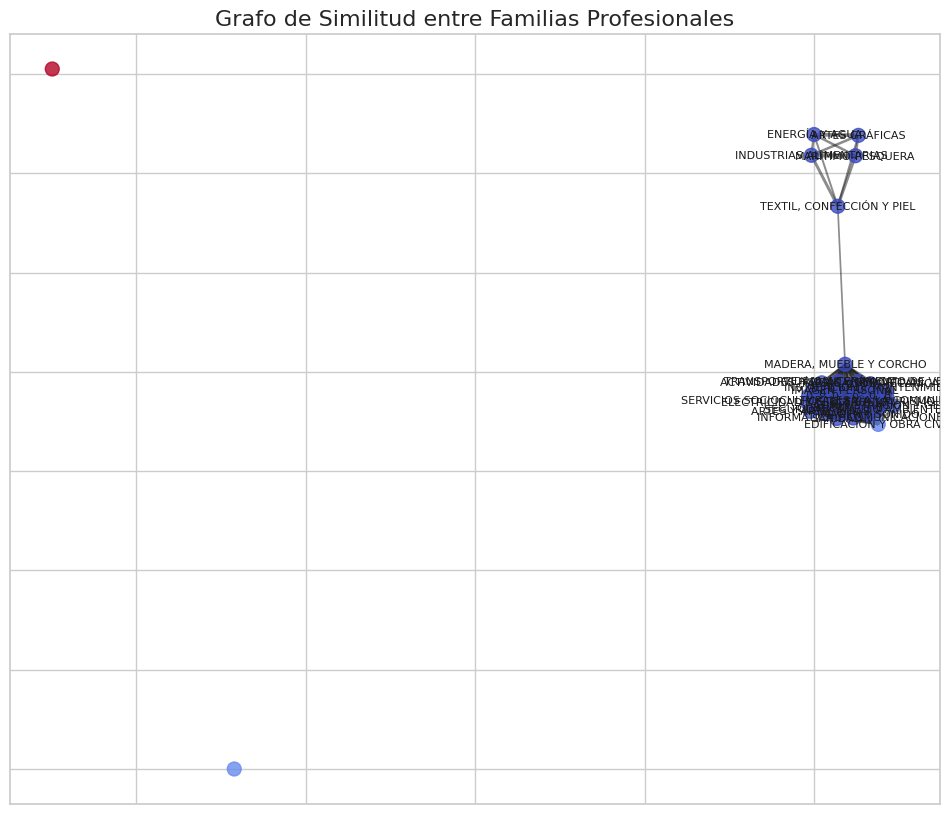

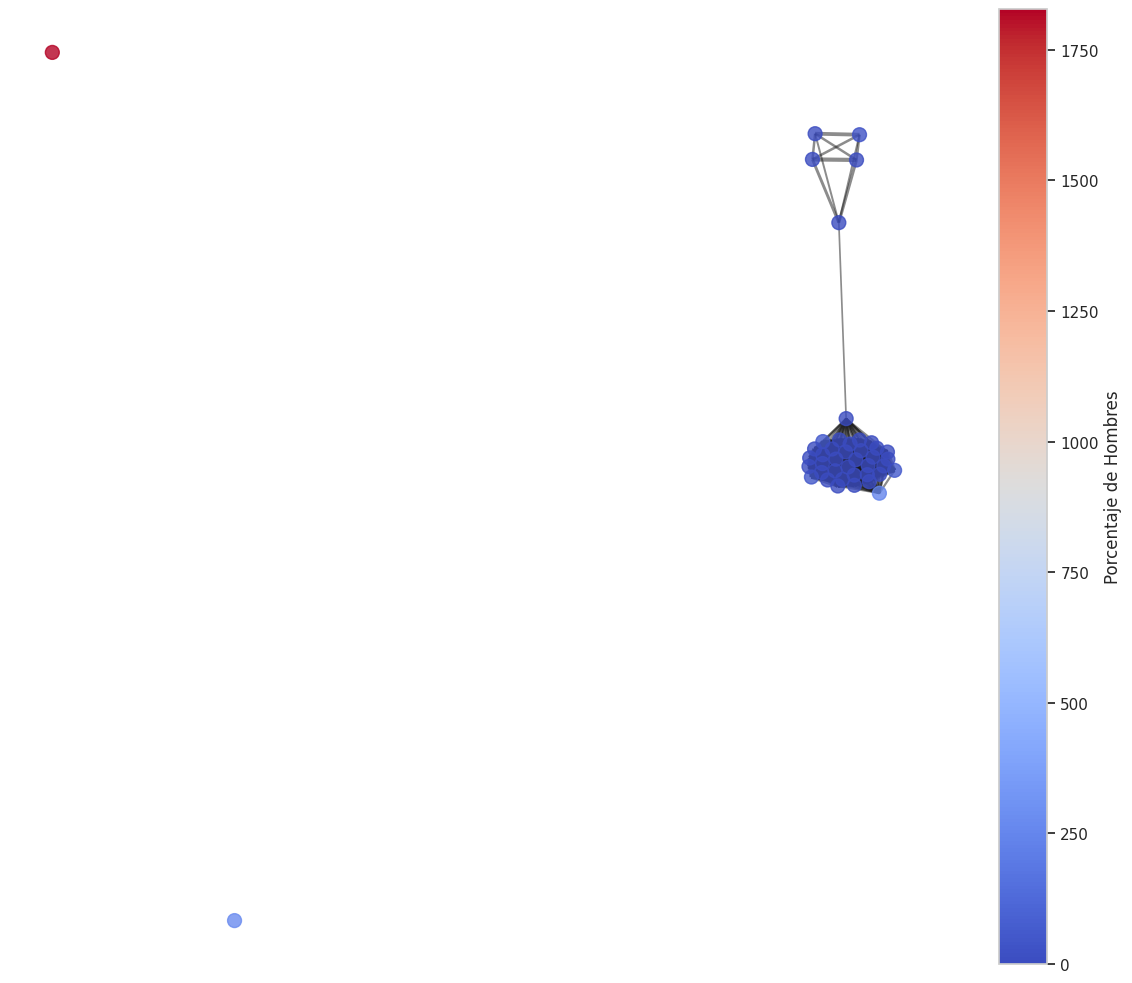


Entrenando modelo GCN...
Epoch 20/100, Loss: 52.9036
Epoch 40/100, Loss: 43.5760
Epoch 60/100, Loss: 27.0901
Epoch 80/100, Loss: 39.9539
Epoch 100/100, Loss: 34.0223

Modelo GCN entrenado.


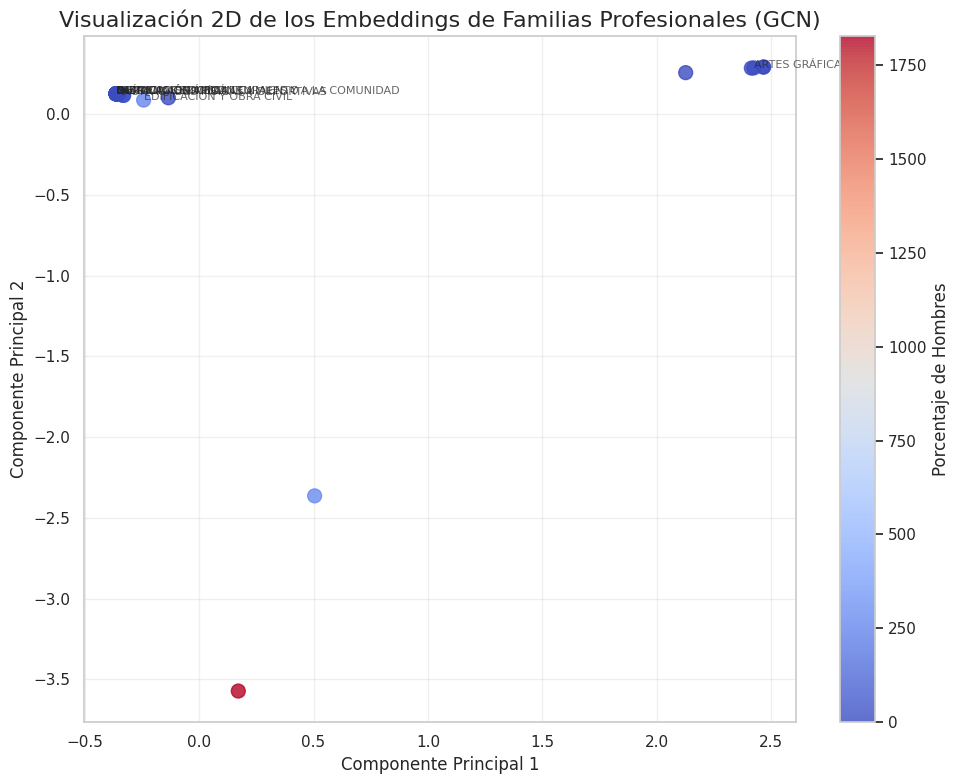


Ejemplos de recomendaciones basadas en GNN:

Para la familia: 0
                      Familia  Similitud  Total_Alumnos  Porcentaje_Hombres  \
0  SEGURIDAD Y MEDIO AMBIENTE        1.0          2.030                 0.0   
1        FABRICACIÓN MECÁNICA        1.0          3.067                 0.0   
2             IMAGEN PERSONAL        1.0          3.089                 0.0   

   Porcentaje_Mujeres  
0                 0.0  
1                 0.0  
2                 0.0  

Para la familia: 0
                      Familia  Similitud  Total_Alumnos  Porcentaje_Hombres  \
0  SEGURIDAD Y MEDIO AMBIENTE        1.0          2.030                 0.0   
1        FABRICACIÓN MECÁNICA        1.0          3.067                 0.0   
2             IMAGEN PERSONAL        1.0          3.089                 0.0   

   Porcentaje_Mujeres  
0                 0.0  
1                 0.0  
2                 0.0  

Para la familia: 0
                      Familia  Similitud  Total_Alumnos  Porcentaje_H

In [34]:
# 6.2 Sistema de Recomendación basado en GNN/GCN
def crear_sistema_recomendacion_gnn(df_alumnado, df_porcentajes):
    """
    Crea un sistema de recomendación basado en Graph Neural Networks (GNN)
    utilizando los datos de alumnado y porcentajes por familia profesional.

    Parámetros:
    df_alumnado (DataFrame): DataFrame con datos de alumnado
    df_porcentajes (DataFrame): DataFrame con porcentajes por familia profesional

    Retorna:
    dict: Diccionario con modelos y funciones
    """

    print("\n--- Sistema de Recomendación basado en GNN/GCN ---")

    # Paso 1: Preparar los datos para construir el grafo
    # Filtrar datos necesarios
    alumnos_familias = df_alumnado[(df_alumnado['Sexo'] == 'AMBOS SEXOS') &
                                  (df_alumnado['Comunidad autónoma/provincia (1)'] == '00 TOTAL')]

    pattern = r'^\d{2}\s'
    alumnos_familias = alumnos_familias[alumnos_familias['Ciclo formativo (2)'].str.match(pattern, na=False)]
    alumnos_familias = alumnos_familias[alumnos_familias['Ciclo formativo (2)'] != '00 TOTAL']
    alumnos_familias['Familia'] = alumnos_familias['Ciclo formativo (2)'].str.slice(3)

    # Filtrar datos por sexo para cada familia
    hombres_familias = df_alumnado[(df_alumnado['Sexo'] == 'Hombres') &
                                 (df_alumnado['Comunidad autónoma/provincia (1)'] == '00 TOTAL')]
    hombres_familias = hombres_familias[hombres_familias['Ciclo formativo (2)'].str.match(pattern, na=False)]
    hombres_familias = hombres_familias[hombres_familias['Ciclo formativo (2)'] != '00 TOTAL']

    mujeres_familias = df_alumnado[(df_alumnado['Sexo'] == 'Mujeres') &
                                 (df_alumnado['Comunidad autónoma/provincia (1)'] == '00 TOTAL')]
    mujeres_familias = mujeres_familias[mujeres_familias['Ciclo formativo (2)'].str.match(pattern, na=False)]
    mujeres_familias = mujeres_familias[mujeres_familias['Ciclo formativo (2)'] != '00 TOTAL']

    # Crear DataFrame para el grafo con las características
    gnn_data = pd.DataFrame()
    gnn_data['Familia'] = alumnos_familias['Familia']
    gnn_data['Total_Alumnos'] = alumnos_familias['Total'].values

    # Añadir los totales por sexo
    for i, familia in enumerate(gnn_data['Familia']):
        # Buscar datos de hombres
        hombres_row = hombres_familias[hombres_familias['Ciclo formativo (2)'].str.slice(3) == familia]
        if not hombres_row.empty:
            gnn_data.loc[i, 'Total_Hombres'] = hombres_row['Total'].values[0]
        else:
            gnn_data.loc[i, 'Total_Hombres'] = 0

        # Buscar datos de mujeres
        mujeres_row = mujeres_familias[mujeres_familias['Ciclo formativo (2)'].str.slice(3) == familia]
        if not mujeres_row.empty:
            gnn_data.loc[i, 'Total_Mujeres'] = mujeres_row['Total'].values[0]
        else:
            gnn_data.loc[i, 'Total_Mujeres'] = 0

    # Calcular porcentajes
    gnn_data['Porcentaje_Hombres'] = (gnn_data['Total_Hombres'] / gnn_data['Total_Alumnos']) * 100
    gnn_data['Porcentaje_Mujeres'] = (gnn_data['Total_Mujeres'] / gnn_data['Total_Alumnos']) * 100

    # Reemplazar NaNs por 0 para evitar problemas
    gnn_data = gnn_data.fillna(0)

    # CORRECCIÓN: Asegurarse de que los índices son contiguos
    gnn_data = gnn_data.reset_index(drop=True)

    # Paso 2: Crear el grafo
    # Primero, crear un grafo de NetworkX
    G = nx.Graph()

    # Añadir nodos al grafo (cada familia profesional es un nodo)
    for i, row in gnn_data.iterrows():
        G.add_node(i,
                  familia=row['Familia'],
                  total_alumnos=row['Total_Alumnos'],
                  porcentaje_hombres=row['Porcentaje_Hombres'],
                  porcentaje_mujeres=row['Porcentaje_Mujeres'])

    # Calcular similitud entre familias para crear aristas
    # Usamos la distancia euclidiana en el espacio de características
    features = ['Total_Alumnos', 'Porcentaje_Hombres', 'Porcentaje_Mujeres']
    X = gnn_data[features].values

    # Verificar y manejar valores NaN de manera más robusta
    if np.isnan(X).any():
        print("Advertencia: Se detectaron valores NaN en las características. Reemplazando con ceros.")
        X = np.nan_to_num(X, nan=0.0)

    # Escalar características
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # CORRECCIÓN: Verificar el número de nodos antes de calcular similitudes
    num_nodos = min(len(G.nodes()), len(X_scaled))

    # Calcular similitudes y añadir aristas
    threshold = 1.5  # Umbral para considerar dos familias como similares
    for i in range(num_nodos):
        for j in range(i+1, num_nodos):
            dist = np.linalg.norm(X_scaled[i] - X_scaled[j])
            if dist < threshold:
                # Añadir arista con peso basado en similitud (inversa de la distancia)
                weight = 1 / (1 + dist)
                G.add_edge(i, j, weight=weight)

    # Paso 3: Verificar que todos los nodos tengan los atributos correctos
    # CORRECCIÓN: Este paso ya no es necesario si todos los nodos se crean correctamente

    # Paso 4: Visualizar el grafo (con comprobación de existencia de atributos)
    plt.figure(figsize=(12, 10))
    pos = nx.spring_layout(G, seed=42)  # Posicionamiento de nodos

    # CORRECCIÓN: Obtener colores de los nodos de manera segura
    node_colors = []
    for i in sorted(G.nodes()):  # Asegurarse de obtener nodos en orden
        node_colors.append(G.nodes[i]['porcentaje_hombres'])

    # Dibujar nodos
    nx.draw_networkx_nodes(G, pos, node_size=100,
                          node_color=node_colors,
                          cmap=plt.cm.coolwarm,
                          alpha=0.8)

    # Dibujar aristas con grosor proporcional al peso
    edges = G.edges(data=True)
    if edges:  # Verificar que haya aristas
        weights = [edge[2].get('weight', 1.0) * 3 for edge in edges]  # Usar get() para evitar KeyError
        nx.draw_networkx_edges(G, pos, width=weights, alpha=0.5)

    # Añadir etiquetas a algunos nodos principales
    # Solo etiquetamos los nodos con más conexiones para no saturar el gráfico
    labels = {}
    for node in G.nodes():
        if G.degree(node) > 3:  # Solo etiquetar nodos con más de 3 conexiones
            labels[node] = G.nodes[node]['familia']

    nx.draw_networkx_labels(G, pos, labels, font_size=8)

    plt.title('Grafo de Similitud entre Familias Profesionales')

    # Create a figure and axes
    fig, ax = plt.subplots(figsize=(12, 10))

    # Draw network components on the axes
    nx.draw_networkx_nodes(G, pos, ax=ax, node_size=100,
                          node_color=node_colors,
                          cmap=plt.cm.coolwarm,
                          alpha=0.8)

    # Verificar aristas nuevamente
    if edges:
        weights = [edge[2].get('weight', 1.0) * 3 for edge in edges]
        nx.draw_networkx_edges(G, pos, ax=ax, width=weights, alpha=0.5)

    # Create a mappable for the colorbar
    mappable = plt.cm.ScalarMappable(cmap=plt.cm.coolwarm)
    mappable.set_array(node_colors)

    # Add the colorbar to the figure
    fig.colorbar(mappable, ax=ax, label='Porcentaje de Hombres')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    # Paso 5: Implementar un modelo GCN simple para embeddings de nodos
    class GCN(nn.Module):
        def __init__(self, n_features, hidden_dim=16, output_dim=8):
            super(GCN, self).__init__()
            self.conv1 = GCNConv(n_features, hidden_dim)
            self.conv2 = GCNConv(hidden_dim, output_dim)

        def forward(self, x, edge_index, edge_weight=None):
            x = F.relu(self.conv1(x, edge_index, edge_weight))
            x = F.dropout(x, training=self.training)
            x = self.conv2(x, edge_index, edge_weight)
            return x

    # Paso 6: Preparar datos para PyTorch Geometric
    # Extraer características de los nodos
    node_features = torch.tensor(X_scaled, dtype=torch.float)

    # Verificar si hay aristas
    if len(G.edges()) == 0:
        print("¡ADVERTENCIA! El grafo no tiene aristas. Ajustando el umbral para generar conexiones...")
        # Si no hay aristas, ajustamos el umbral automáticamente
        all_dists = []
        for i in range(num_nodos):
            for j in range(i+1, num_nodos):
                all_dists.append(np.linalg.norm(X_scaled[i] - X_scaled[j]))

        # Usar el percentil 25 como nuevo umbral
        if all_dists:
            threshold = np.percentile(all_dists, 25)
            print(f"Nuevo umbral: {threshold}")

            # CORRECCIÓN: Recalcular aristas solo dentro del rango válido de nodos
            for i in range(num_nodos):
                for j in range(i+1, num_nodos):
                    dist = np.linalg.norm(X_scaled[i] - X_scaled[j])
                    if dist < threshold:
                        weight = 1 / (1 + dist)
                        G.add_edge(i, j, weight=weight)
        else:
            print("Error: No se pudieron calcular distancias entre nodos.")
            # CORRECCIÓN: Añadir aristas solo entre nodos válidos
            for i in range(num_nodos):
                j = (i + 1) % num_nodos  # conectar en círculo
                G.add_edge(i, j, weight=0.5)

    # Extraer aristas (después de la verificación)
    edges = list(G.edges())
    edge_index = torch.tensor([[u, v] for u, v in edges] + [[v, u] for u, v in edges], dtype=torch.long).t()

    # Extraer pesos de las aristas
    edge_weight = torch.tensor([G[u][v].get('weight', 1.0) for u, v in edges] +
                             [G[u][v].get('weight', 1.0) for u, v in edges], dtype=torch.float)

    # Crear objeto de datos de PyTorch Geometric
    data = Data(x=node_features, edge_index=edge_index, edge_weight=edge_weight)

    # Paso 7: Entrenar modelo GCN
    model = GCN(n_features=X_scaled.shape[1])
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    # Función para obtener recomendaciones basadas en embeddings
    def obtener_recomendaciones_gnn(familia_input, n_recomendaciones=3):
        """
        Obtiene recomendaciones basadas en embeddings de GNN.

        Parámetros:
        familia_input (str): Nombre de la familia profesional
        n_recomendaciones (int): Número de recomendaciones a devolver

        Retorna:
        DataFrame con las familias recomendadas
        """
        # Verificar si la familia existe
        if familia_input not in gnn_data['Familia'].values:
            print(f"La familia '{familia_input}' no está en los datos.")
            return None

        # Obtener índice de la familia
        idx = gnn_data[gnn_data['Familia'] == familia_input].index[0]

        # Obtener embedding del nodo
        model.eval()
        with torch.no_grad():
            node_embeddings = model(data.x, data.edge_index, data.edge_weight)

        # Calcular similitud con todas las demás familias
        query_embedding = node_embeddings[idx]
        similarities = []

        for i, emb in enumerate(node_embeddings):
            if i != idx and i < len(gnn_data):  # CORRECCIÓN: Asegurarse de que el índice es válido
                # Calcular similitud de coseno
                sim = F.cosine_similarity(query_embedding.unsqueeze(0), emb.unsqueeze(0)).item()
                similarities.append((i, sim))

        # Ordenar por similitud y obtener las n_recomendaciones mejores
        top_similarities = sorted(similarities, key=lambda x: x[1], reverse=True)[:n_recomendaciones]

        # Crear DataFrame con las recomendaciones
        recomendaciones = pd.DataFrame()
        recomendaciones['Familia'] = [gnn_data.iloc[i]['Familia'] for i, _ in top_similarities]
        recomendaciones['Similitud'] = [sim for _, sim in top_similarities]

        # Añadir características relevantes
        for feature in features:
            recomendaciones[feature] = [gnn_data.iloc[i][feature] for i, _ in top_similarities]

        return recomendaciones

    # Entrenar el modelo (simplificado para este ejemplo)
    print("\nEntrenando modelo GCN...")
    model.train()
    for epoch in range(100):
        optimizer.zero_grad()
        # En un escenario real, aquí tendríamos una función de pérdida apropiada
        # Para este ejemplo, haremos un forward pass simple
        out = model(data.x, data.edge_index, data.edge_weight)
        # Como no tenemos etiquetas, usamos una pérdida de reconstrucción simple
        loss = torch.norm(torch.mm(out, out.t()) - torch.mm(data.x, data.x.t()))
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 20 == 0:
            print(f"Epoch {epoch+1}/100, Loss: {loss.item():.4f}")

    print("\nModelo GCN entrenado.")

    # Generar embeddings finales de manera segura
    model.eval()
    with torch.no_grad():
        node_embeddings = model(data.x, data.edge_index, data.edge_weight).detach().numpy()

    # Verificar NaN en los embeddings antes de PCA
    if np.isnan(node_embeddings).any():
        print("Advertencia: Se detectaron valores NaN en los embeddings. Reemplazando con ceros.")
        node_embeddings = np.nan_to_num(node_embeddings, nan=0.0)

    # CORRECCIÓN: Asegurarse de que solo usamos embeddings para nodos válidos
    valid_embeddings = node_embeddings[:len(gnn_data)]

    # Paso 8: Visualizar embeddings con PCA
    # Aplicar PCA para visualizar en 2D
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(valid_embeddings)

    # Crear un DataFrame con los embeddings y metadatos
    embeddings_df = pd.DataFrame(embeddings_2d, columns=['PC1', 'PC2'])
    embeddings_df['Familia'] = gnn_data['Familia'].values
    embeddings_df['Porcentaje_Hombres'] = gnn_data['Porcentaje_Hombres'].values

    # Visualizar
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(embeddings_df['PC1'], embeddings_df['PC2'],
                         c=embeddings_df['Porcentaje_Hombres'],
                         cmap='coolwarm',
                         alpha=0.8,
                         s=100)

    # Añadir etiquetas a algunos puntos
    for i, row in embeddings_df.iterrows():
        # Etiquetar solo algunos puntos para no saturar la visualización
        if i % 3 == 0:  # Etiquetar cada tercer punto
            plt.annotate(row['Familia'],
                        (row['PC1'], row['PC2']),
                        fontsize=8,
                        alpha=0.7)

    plt.colorbar(scatter, label='Porcentaje de Hombres')
    plt.title('Visualización 2D de los Embeddings de Familias Profesionales (GCN)')
    plt.xlabel('Componente Principal 1')
    plt.ylabel('Componente Principal 2')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Paso 9: Demostrar el sistema de recomendación
    print("\nEjemplos de recomendaciones basadas en GNN:")

    # Seleccionar algunas familias de ejemplo (asegurarse de que hay suficientes)
    num_ejemplos = min(3, len(gnn_data))
    if num_ejemplos > 0:
        familias_ejemplo = gnn_data['Familia'].sample(num_ejemplos).values

        for familia in familias_ejemplo:
            print(f"\nPara la familia: {familia}")
            recomendaciones = obtener_recomendaciones_gnn(familia)
            if recomendaciones is not None:
                print(recomendaciones[['Familia', 'Similitud', 'Total_Alumnos', 'Porcentaje_Hombres', 'Porcentaje_Mujeres']])
    else:
        print("No hay suficientes datos para generar ejemplos de recomendación.")

    # Paso 10: Comparar con PageRank para identificar familias influyentes
    print("\nFamilias profesionales más influyentes según PageRank:")
    try:
        pagerank = nx.pagerank(G, weight='weight')
        pagerank_df = pd.DataFrame(list(pagerank.items()), columns=['Índice', 'PageRank'])

        # CORRECCIÓN: Filtrar solo los nodos que tienen atributos válidos
        valid_indices = [idx for idx in pagerank_df['Índice'] if idx in G.nodes() and 'familia' in G.nodes[idx]]
        pagerank_df = pagerank_df[pagerank_df['Índice'].isin(valid_indices)]

        pagerank_df['Familia'] = pagerank_df['Índice'].apply(lambda x: G.nodes[x]['familia'])
        pagerank_df = pagerank_df.sort_values('PageRank', ascending=False)

        top_n = min(5, len(pagerank_df))
        if top_n > 0:
            print(pagerank_df[['Familia', 'PageRank']].head(top_n))
        else:
            print("No hay suficientes datos para el análisis PageRank.")
    except Exception as e:
        print(f"Error al calcular PageRank: {e}")
        pagerank_df = pd.DataFrame(columns=['Índice', 'PageRank', 'Familia'])

    # Retornar modelos y funciones
    return {
        'graph': G,
        'model': model,
        'data': data,
        'embeddings': valid_embeddings,  # CORRECCIÓN: Retornar solo los embeddings válidos
        'get_recommendations': obtener_recomendaciones_gnn,
        'gnn_data': gnn_data,
        'feature_names': features,
        'pagerank': pagerank_df
    }

# Para ejecutar la función, es necesario pasar los dataframes como parámetros
resultado_gnn = crear_sistema_recomendacion_gnn(df_alumnado, df_porcentajes)

# Comparación precisión KNN - GNN

In [37]:
# Función para evaluar KNN y GNN
def comparar_precision_knn_gnn(resultado_knn, resultado_gnn, familias_prueba, n_recomendaciones=3):
    """
    Compara la precisión de los sistemas de recomendación basados en KNN y GNN.
    Parámetros:
    resultado_knn (dict): Resultados del sistema de recomendación KNN.
    resultado_gnn (dict): Resultados del sistema de recomendación GNN.
    familias_prueba (list): Lista de familias profesionales para probar.
    n_recomendaciones (int): Número de recomendaciones a considerar.
    Retorna:
    dict: Diccionario con las métricas de precisión para KNN y GNN.
    """
    metricas = {'knn': {'precision': [], 'recall': [], 'similitud_promedio': []},
                'gnn': {'precision': [], 'recall': [], 'similitud_promedio': []}}

    for familia in familias_prueba:
        # Obtener recomendaciones de KNN
        recomendaciones_knn = resultado_knn['recomendar_familias_similares'](familia, n_recomendaciones)
        # Obtener recomendaciones de GNN
        recomendaciones_gnn = resultado_gnn['get_recommendations'](familia, n_recomendaciones)

        # Calcular métricas para KNN
        if recomendaciones_knn is not None:
            precision_knn = calcular_precision(recomendaciones_knn, familia)
            recall_knn = calcular_recall(recomendaciones_knn, familia)
            similitud_knn = calcular_similitud_promedio(recomendaciones_knn, familia)
            metricas['knn']['precision'].append(precision_knn)
            metricas['knn']['recall'].append(recall_knn)
            metricas['knn']['similitud_promedio'].append(similitud_knn)

        # Calcular métricas para GNN
        if recomendaciones_gnn is not None:
            precision_gnn = calcular_precision(recomendaciones_gnn, familia)
            recall_gnn = calcular_recall(recomendaciones_gnn, familia)
            similitud_gnn = calcular_similitud_promedio(recomendaciones_gnn, familia)
            metricas['gnn']['precision'].append(precision_gnn)
            metricas['gnn']['recall'].append(recall_gnn)
            metricas['gnn']['similitud_promedio'].append(similitud_gnn)

    # Calcular promedios
    for modelo in metricas:
        for metrica in metricas[modelo]:
            if metricas[modelo][metrica]:  # Verificar que la lista no esté vacía
                metricas[modelo][metrica] = np.mean(metricas[modelo][metrica])
            else:
                metricas[modelo][metrica] = 0.0

    return metricas

# Visualización de recomendaciones

In [ ]:
# Función para visualizar recomendaciones con gráficos interactivos
def visualizar_recomendaciones(knn_data, knn_model, X_scaled, familia_input):
    """
    Genera un gráfico de red para visualizar recomendaciones de familias similares.
    """
    print(f"\nVisualizando recomendaciones para la familia: {familia_input}")

    # Obtener índice de la familia de entrada
    if familia_input not in knn_data['Familia'].values:
        print("Familia no encontrada en los datos.")
        return

    idx = knn_data[knn_data['Familia'] == familia_input].index[0]
    input_features = X_scaled[idx].reshape(1, -1)

    # Obtener vecinos más cercanos
    distances, indices = knn_model.kneighbors(input_features, n_neighbors=5)
    recommended_families = knn_data.iloc[indices[0]]['Familia'].values

    # Crear gráfico de red
    G = nx.Graph()
    G.add_node(familia_input, color='red', size=500)

    for fam in recommended_families:
        G.add_node(fam, color='blue', size=300)
        G.add_edge(familia_input, fam)

    colors = [G.nodes[n]['color'] for n in G.nodes]
    sizes = [G.nodes[n]['size'] for n in G.nodes]

    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color=colors, node_size=sizes, edge_color='gray')
    plt.title(f"Recomendaciones para {familia_input}")
    plt.show()


# Personalización avanzada
Permite a los estudiantes ingresar preferencias más detalladas (género, tamaño de familia, interés específico) para recibir recomendaciones más precisas.

In [ ]:
# Función de personalización avanzada
def recomendar_por_perfil_avanzado(knn_data, sexo, preferencia_tamano, preferencia_genero, interes_especifico, n_recomendaciones=5):
    """
    Recomienda familias profesionales basadas en un perfil más detallado del usuario.
    """
    recommendations = knn_data.copy()
    recommendations['Puntuación'] = 0

    # Evaluar género
    if sexo == 'Hombre':
        recommendations['Puntuación'] += recommendations['Porcentaje_Hombres'] / 10
    else:
        recommendations['Puntuación'] += recommendations['Porcentaje_Mujeres'] / 10

    # Evaluar tamaño
    if preferencia_tamano == 'Grande':
        recommendations['Puntuación'] += recommendations['Total_Alumnos'] / recommendations['Total_Alumnos'].max() * 5
    elif preferencia_tamano == 'Pequeña':
        recommendations['Puntuación'] += (1 - recommendations['Total_Alumnos'] / recommendations['Total_Alumnos'].max()) * 5

    # Evaluar interés específico
    if interes_especifico:
        recommendations['Puntuación'] += recommendations['Familia'].apply(lambda x: 5 if interes_especifico.lower() in x.lower() else 0)

    recommendations = recommendations.sort_values('Puntuación', ascending=False)
    return recommendations.head(n_recomendaciones)
